# Sowing by seasonal climate forecast

* **Compatibility:** We use matplotlib.pyplot.subplots with cartopy projection for mapping. The attribute ".set_extent" doesn't work here so we use the attributes ".set_xlim" and ".set_ylim" instead (code cell 2). The conventional series indexing i.e. series[i:j] might not work properly here and in future versions of pandas or numpy, we thus use series.iloc[i:j] instead (code cell 19).
* **Products used:** GRDC + CSIRO + UniSQ + UQ's calibrated wheat yield simulation database with frost and heat impacts ([An-Vo et al. 2018, Ecological Economics](https://www.sciencedirect.com/science/article/pii/S0921800916314203)). We also used the ENSO phases forecasting system including uncertainty parameterisation developed in [An-Vo et al. (2019), European Journal of Agronomy](https://www.sciencedirect.com/science/article/pii/S1161030118301990).  

## Background

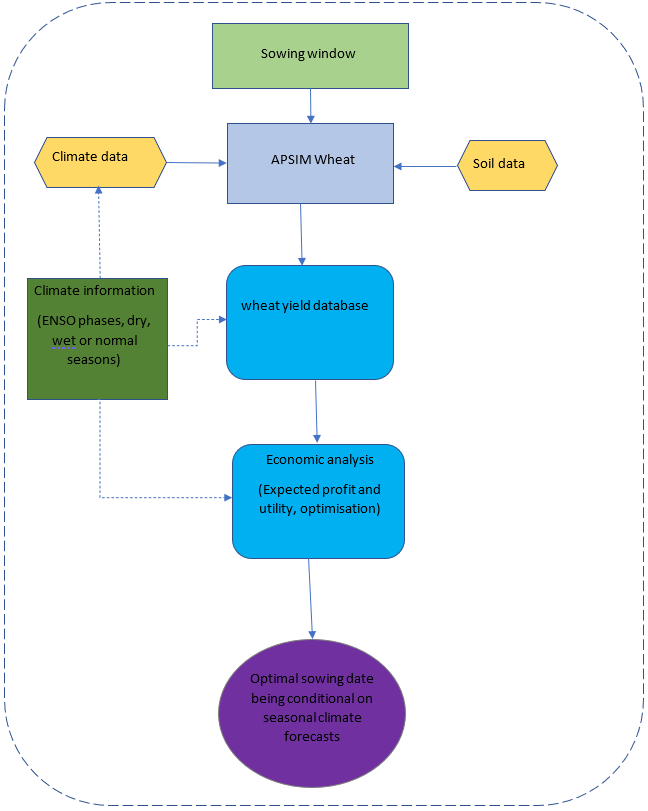

Parameterisation for the seasonal forecasting systems  of seasonal precipitation tercile is given by

|Forecast\Outcome  | Wet  | Normal  | Dry  |
|----   |-----   |----    |----- |           
|Wet    | $q_1$  | $1-q_1 \over 2$ | $1-q_1 \over 2$ |   
|Normal | $1-q_2 \over 2$    | $q_2$  | $1-q_2 \over 2$|
|Dry    | $1-q_3 \over 2$    | $1-q_3 \over 2$  | $q_3$ |      


## Description
We can learn:
* How to use API to access a datasource (e.g. SILO) by its url.
* How to use masks to identify different climatic conditions.
* How to use bracket loop for grouping a list of text objects in yticklabels.

## Getting started

In [1]:
# Loading modules and packages
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
#import plotly.express as px
import pandas as pd
#import json
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import numpy as np
import netCDF4
from netCDF4 import num2date, date2num, date2index  # To deal with time variables
from scipy import signal
import math
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mapclassify as mc
from datetime import datetime
import urllib.request                               # To work with SILO url
import urllib.parse                                 # To work with SILO url
import io                                           # To instantiate the file-like object of data in byte type with API access     

## Formulating the application

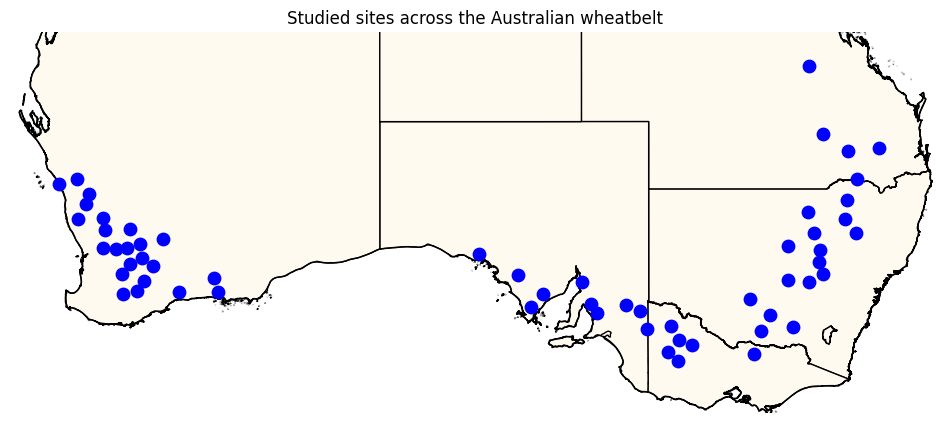

In [4]:
# Loading required data other than wheat yield data
stations = r'stations.csv'                                                # Data regarding information for studied sites
# Loading the data
dfS = pd.read_csv(stations, sep = r'\s*,\s*', engine = 'python')
#dfS

# Using geopandas to convert long and lat to points
dfG = gpd.GeoDataFrame(dfS, geometry = gpd.points_from_xy(
dfS.Longitude, dfS.Latitude))
#dfG

# Loading shapefile for Australia states
states_path = 'STE_2021_AUST_GDA2020.shp'                                 # Shapefile for Australia states
state_feature = ShapelyFeature(Reader(states_path).geometries(),          # Get the state features for later mapping
                               crs=ccrs.PlateCarree(), 
                               edgecolor = 'black')
shapefile = gpd.read_file(states_path)
#shapefile

# Mapping the studied sites
fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()))
#ax.set_extent([112.5, 154, -37, -22])    # The attribute ".set_exent" does not work here
ax.set_xlim([112.5, 154])
ax.set_ylim([-39, -22])
ax.coastlines(color='black', linewidth=1, resolution='50m')
ax.set_title('Studied sites across the Australian wheatbelt')
ax.set_axis_off()
ax.add_feature(state_feature, 
                     facecolor="floralwhite", 
                     zorder=1)
dfG.plot(ax = ax, color = 'b', markersize=80, zorder=2)
fig.set_size_inches(12,8)

## Wheat yield database

In [5]:
# Loading the frosted wheat yield database
frost_yield = r'fiFrostImpactYearly_n.csv'
dfY = pd.read_csv(frost_yield, index_col = 'sites')
dfY

,Year,nitrogen,sowing_date,cultivar,post_head,yield,nsowing,n30,n37,flow_das
sites,,,,,,,,,,
8025,1957,0,91,Medium,5,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,4,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,3,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,2,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,1,890.640002,20.0,30.0,6.0,81.0
...,...,...,...,...,...,...,...,...,...,...
89016,2013,140,181,Medium,3,2334.420000,50.0,120.0,0.0,125.0
89016,2013,140,181,Medium,2,2334.420000,50.0,120.0,0.0,125.0
89016,2013,140,181,Medium,1,2334.420000,50.0,120.0,0.0,125.0


## Working with wheat yield data at a site 

In [6]:
# Extract wheat yield data for a site  
dfY_Dubbo = dfY.loc[dfS.loc[7, "Weather Station"], :]          # At Dubbo
# Extract wheat yield data for current genotype at the site
dfY0_Dubbo = dfY_Dubbo[dfY_Dubbo['post_head'] == '0']
# Extract wheat yield data with no extra nitrogen added
dfY0_n0_Dubbo = dfY0_Dubbo[dfY0_Dubbo['nitrogen'] == 0]
dfY0_n0_Dubbo.head(91)

,Year,nitrogen,sowing_date,cultivar,post_head,yield,nsowing,n30,n37,flow_das
sites,,,,,,,,,,
65012,1957,0,91,Medium,0,0.003646,50.0,0.0,0.0,116.0
65012,1957,0,92,Medium,0,0.004833,50.0,0.0,0.0,117.0
65012,1957,0,93,Medium,0,0.018445,50.0,0.0,0.0,118.0
65012,1957,0,94,Medium,0,0.068287,50.0,0.0,0.0,119.0
65012,1957,0,95,Medium,0,0.173057,50.0,0.0,0.0,120.0
...,...,...,...,...,...,...,...,...,...,...
65012,1957,0,177,Medium,0,785.022278,50.0,50.0,0.0,116.0
65012,1957,0,178,Medium,0,776.813574,50.0,50.0,0.0,116.0
65012,1957,0,179,Medium,0,764.089697,50.0,50.0,0.0,115.0


In [7]:
# Set years as the row index
dfY_Site = dfY0_n0_Dubbo.set_index('Year')
dfY_Site.head(92)

,nitrogen,sowing_date,cultivar,post_head,yield,nsowing,n30,n37,flow_das
Year,,,,,,,,,
1957,0,91,Medium,0,3.645520e-03,50.0,0.0,0.0,116.0
1957,0,92,Medium,0,4.832705e-03,50.0,0.0,0.0,117.0
1957,0,93,Medium,0,1.844521e-02,50.0,0.0,0.0,118.0
1957,0,94,Medium,0,6.828677e-02,50.0,0.0,0.0,119.0
1957,0,95,Medium,0,1.730566e-01,50.0,0.0,0.0,120.0
...,...,...,...,...,...,...,...,...,...
1957,0,178,Medium,0,7.768136e+02,50.0,50.0,0.0,116.0
1957,0,179,Medium,0,7.640897e+02,50.0,50.0,0.0,115.0
1957,0,180,Medium,0,7.494568e+02,50.0,50.0,0.0,115.0


In [8]:
# Construct a dataframe of yields and current nitrogen across the sowing window for all simulated years
dfYield = pd.DataFrame({})
dfN = pd.DataFrame({})
for i in np.arange(1957, 2014, 1):
    dfYield[i] = dfY_Site.loc[i, 'yield'].array                                                             # Yields
    dfN[i] = (dfY_Site.loc[i, 'nsowing'] + dfY_Site.loc[i, 'n30'] + dfY_Site.loc[i, 'n37']).array           # Nitrogen
dfYield    

,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,0.003646,9.003344e-08,4.287120,0.059179,2.227078e-07,1.773694,0.000001,1.745169e-08,6.550577e-08,2.035530e-08,...,4.164663e-09,0.000008,1.165822e-07,0.000016,1.197752e-11,9.333042e-07,4.577728e-08,0.000030,6.956566e-15,9.511541e-10
1,0.004833,6.822808e-08,3.500560,0.110018,4.381534e-07,3.590787,0.000002,3.260083e-07,3.512851e-07,2.740575e-08,...,5.810884e-09,0.000006,2.060232e-07,0.000019,1.700814e-11,6.849078e-07,8.453584e-07,0.000079,8.351212e-15,1.341282e-09
2,0.018445,1.344282e-07,3.428240,0.165126,8.514244e-07,7.791978,0.000004,2.511373e-06,2.637220e-06,3.049636e-08,...,1.107333e-08,0.000004,3.238492e-07,0.000018,4.212245e-11,4.945509e-07,2.558552e-06,0.000233,8.595578e-15,1.872157e-09
3,0.068287,2.819409e-07,3.410780,0.229925,1.473399e-06,12.161418,0.000005,1.122651e-05,3.338232e-05,3.383670e-08,...,2.327757e-08,0.000003,5.778948e-07,0.000021,5.672696e-11,3.216700e-07,7.532047e-06,0.000608,7.044015e-15,2.620513e-09
4,0.173057,3.629610e-07,3.429840,0.337475,2.994266e-06,24.522943,0.000007,2.088586e-05,1.578100e-04,6.724686e-08,...,4.517540e-08,0.000003,9.622540e-07,0.000024,8.013584e-11,6.322214e-07,2.805641e-05,0.000958,5.006762e-15,4.100279e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,785.022278,1.023176e+03,1846.600024,2207.476758,2.389889e+03,2799.940039,3401.780029,4.389900e+03,2.100906e+03,4.215440e+03,...,2.025081e+03,3469.480000,8.109064e+02,1105.018000,1.391154e+03,5.382980e+02,3.962460e+03,3386.200000,7.357770e+02,1.296485e+03
87,776.813574,7.189952e+02,1854.780029,2195.100000,2.378533e+03,2769.000049,3388.039941,4.376940e+03,1.478925e+03,4.191360e+03,...,2.006921e+03,3562.700000,8.051463e+02,1098.501000,1.389662e+03,5.384372e+02,3.922660e+03,3420.680000,7.341280e+02,1.298223e+03
88,764.089697,8.190477e+02,1483.552026,2159.978320,2.396012e+03,2775.659961,3746.860010,4.347360e+03,1.485162e+03,4.098260e+03,...,1.999048e+03,3557.480000,7.250880e+02,1017.130000,1.383545e+03,5.287686e+02,3.890100e+03,3347.420000,7.266735e+02,1.113554e+03
89,749.456787,8.159008e+02,1500.864063,2151.538281,2.398232e+03,2740.360010,3696.020020,4.429320e+03,1.490920e+03,4.045880e+03,...,1.983091e+03,3596.660000,7.300440e+02,1024.376000,1.370990e+03,5.269996e+02,3.870880e+03,3386.140000,7.190150e+02,1.085356e+03


In [9]:
dfN

,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,50.0,50.0,100.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
1,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
2,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
3,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
4,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,100.0,50.0,50.0,100.0,100.0,100.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,100.0,50.0,50.0,50.0
87,100.0,50.0,50.0,100.0,100.0,100.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,100.0,50.0,50.0,50.0
88,100.0,100.0,50.0,100.0,100.0,100.0,100.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,100.0,50.0,50.0,50.0
89,100.0,100.0,50.0,100.0,100.0,100.0,100.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,100.0,50.0,50.0,50.0


In [10]:
# Climate data for the site
#climate_data = r'Carnamah8025.csv'
#dfC = pd.read_csv(climate_data)

# Another way is to use API for SILO station data
api_url = 'https://www.longpaddock.qld.gov.au/cgi-bin/silo'
params = {
    'format': 'csv',
    'station': '65012',
    'start': '19570101',
    'finish': '20131231',
    'username': 'duc-anh.an-vo@usq.edu.au',
    'comment': 'R'
}    
url = api_url + '/PatchedPointDataset.php?' + urllib.parse.urlencode(params)
with urllib.request.urlopen(url) as remote:
    data = remote.read()
datafile = io.StringIO(data.decode())       # Instantiate the file-like object
dfC = pd.read_csv(datafile)
dfC

,station,YYYY-MM-DD,daily_rain,daily_rain_source,metadata
0,65012,1957-01-01,0.0,0,name=DUBBO (DARLING STREET)
1,65012,1957-01-02,0.0,0,latitude= -32.2385
2,65012,1957-01-03,0.3,0,longitude= 148.6089
3,65012,1957-01-04,1.0,0,elevation= 260.0 m
4,65012,1957-01-05,3.8,0,reference=R
...,...,...,...,...,...
20814,65012,2013-12-27,0.0,25,NaN
20815,65012,2013-12-28,0.0,25,NaN
20816,65012,2013-12-29,0.0,25,NaN
20817,65012,2013-12-30,0.0,25,NaN


In [11]:
# Create a dataframe for daily rainfall at the site indexing by the years 
Year = [datetime.strptime(dfC['YYYY-MM-DD'][i],'%Y-%m-%d').year for i, _ in dfC.iterrows()]      # Create a list for years
dfR = pd.DataFrame({})
dfR['Year'] = Year
dfR['Rain'] = dfC.daily_rain
dfR = dfR.set_index('Year')
dfR
#dfR.loc[1957,:]

,Rain
Year,
1957,0.0
1957,0.0
1957,0.3
1957,1.0
1957,3.8
...,...
2013,0.0
2013,0.0
2013,0.0


In [12]:
# Construct a seasonal rainfall dataframe based on each sowing date from 1957 to 2013
SR = pd.DataFrame({})
for i in np.arange(1957, 2014, 1):
    Rain = dfR.loc[i,:]
    seasonal_Rain = []
    for j in np.arange(90, 181, 1):
        #flow_d = dfY_Site.flow_das[i].iloc[j-90]                         # Determine the flowering date corresponding to a sowing date
        #seasonal_R = Rain.iloc[j:j+int(flow_d),0].sum()                  # Total seasonal rainfall for a sowing date (from sowing date to flowering date)
        seasonal_R = Rain.iloc[j:j+150,0].sum()                           # Seasonal rainfall estimated from the sowing date to 150 days after sowing
        seasonal_Rain.append(seasonal_R)
    SR[i] = seasonal_Rain
SR

,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,157.4,215.3,278.4,233.9,239.1,214.9,289.4,247.3,119.5,194.7,...,167.3,147.2,101.8,187.9,98.8,178.0,275.3,165.0,193.4,178.5
1,157.4,215.6,191.7,233.9,239.1,214.9,312.5,247.3,119.5,194.7,...,167.3,147.2,101.8,187.9,98.8,178.0,273.4,165.0,193.4,178.5
2,157.4,215.6,144.7,233.9,239.1,214.9,313.0,247.3,119.5,194.7,...,167.3,147.2,101.8,187.9,98.8,178.0,273.4,165.0,193.4,178.5
3,157.4,215.6,112.9,233.2,239.1,214.9,313.0,250.1,119.5,203.8,...,173.1,147.2,104.8,187.9,98.8,178.0,273.4,165.0,193.4,178.5
4,157.4,215.6,109.3,233.2,239.1,211.1,313.0,250.1,119.5,217.5,...,189.1,146.2,104.8,187.9,115.4,168.3,273.4,165.0,193.4,178.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,119.4,289.9,121.0,284.8,311.5,203.5,251.8,313.6,189.2,293.5,...,206.8,334.3,87.4,119.9,243.6,100.9,341.0,232.4,137.2,145.7
87,119.4,289.9,119.5,303.9,311.5,203.5,251.8,313.6,189.2,293.5,...,206.8,339.2,87.4,115.9,243.6,101.1,325.8,249.9,137.1,145.7
88,119.4,289.9,135.5,303.9,311.5,203.5,252.3,312.3,189.2,294.0,...,206.8,340.5,87.4,114.9,243.6,99.1,325.7,257.8,137.1,145.7
89,119.4,285.8,134.7,303.9,311.5,203.5,252.3,312.3,189.7,294.3,...,206.8,347.3,87.4,100.5,243.6,98.5,325.7,288.5,137.1,125.4


In [13]:
# Construct expected yields and gross margins in all years and in the three climatic conditions across the sowing window
Ys = []        # Yields in all years
LYs = []       # Yields in dry years
NYs = []       # Yields in normal years
UYs = []       # Yields in wet years
#
GMs = []       # Gross margin in all years
GM_LYs = []    # Gross margin in dry years
GM_NYs = []    # Gross margin in normal years
GM_UYs = []    # Gross margin in wet years
for i, _ in SR.iterrows():
    Y = dfYield.loc[i,:].mean()
    GM = (dfYield.loc[i,:]*0.001*238-216.4 - dfN.loc[i,:]*564/460).mean()                        # For gross margin estimation, please refer to An-Vo et al. (2018)
    #
    LQ = np.quantile(SR.loc[i,:].array, 1/3)          # Bottom tercile
    UQ = np.quantile(SR.loc[i,:].array, 2/3)          # Top tercile
    #
    mask_L = SR.loc[i,:].lt(LQ)                       # Mask for low yields
    mask_U = SR.loc[i,:].gt(UQ)                       # Mask for high yields
    mask_N = SR.loc[i,:].ge(LQ) & SR.loc[i,:].le(UQ)  # Mask for normal yields
    #
    LY = dfYield.loc[i, mask_L].mean()                # Expected yield in dry years
    UY = dfYield.loc[i, mask_U].mean()                # Expected yield in wet years
    NY = dfYield.loc[i, mask_N].mean()                # Expected yield in normal years
    #
    GM_LY = (dfYield.loc[i, mask_L]*0.001*238-216.4 - dfN.loc[i, mask_L]*564/460).mean()
    GM_UY = (dfYield.loc[i, mask_U]*0.001*238-216.4 - dfN.loc[i, mask_U]*564/460).mean()
    GM_NY = (dfYield.loc[i, mask_N]*0.001*238-216.4 - dfN.loc[i, mask_N]*564/460).mean()
    #
    Ys.append(Y)
    LYs.append(LY)
    NYs.append(NY)
    UYs.append(UY)
    #
    GMs.append(GM)
    GM_LYs.append(GM_LY)
    GM_NYs.append(GM_NY)
    GM_UYs.append(GM_UY)
#
Ys = pd.Series(Ys)
LYs = pd.Series(LYs)
NYs = pd.Series(NYs)
UYs = pd.Series(UYs)
#
GMs = pd.Series(GMs)
GM_LYs = pd.Series(GM_LYs)
GM_NYs = pd.Series(GM_NYs)
GM_UYs = pd.Series(GM_UYs)
GMs

0    -263.152615
1    -260.558893
2    -260.074099
3    -259.169020
4    -259.485759
         ...    
86    262.262799
87    253.928664
88    249.542410
89    247.212883
90    243.200497
Length: 91, dtype: float64

In [14]:
# Create a series of sowing days for plotting
sd = pd.date_range('2011-04-01', periods= 91, freq='D')
sd = pd.Series(sd, index = np.arange(91,182,1))
sd = sd.dt.strftime('%m-%d') 
sd.head(30)

91     04-01
92     04-02
93     04-03
94     04-04
95     04-05
96     04-06
97     04-07
98     04-08
99     04-09
100    04-10
101    04-11
102    04-12
103    04-13
104    04-14
105    04-15
106    04-16
107    04-17
108    04-18
109    04-19
110    04-20
111    04-21
112    04-22
113    04-23
114    04-24
115    04-25
116    04-26
117    04-27
118    04-28
119    04-29
120    04-30
dtype: object

The optimal sowing date at Dubbo in all years is: 06-02

The optimal sowing date at Dubbo in dry years is: 05-10

The optimal sowing date at Dubbo in normal years is: 05-31

The optimal sowing date at Dubbo in wet years is: 06-12



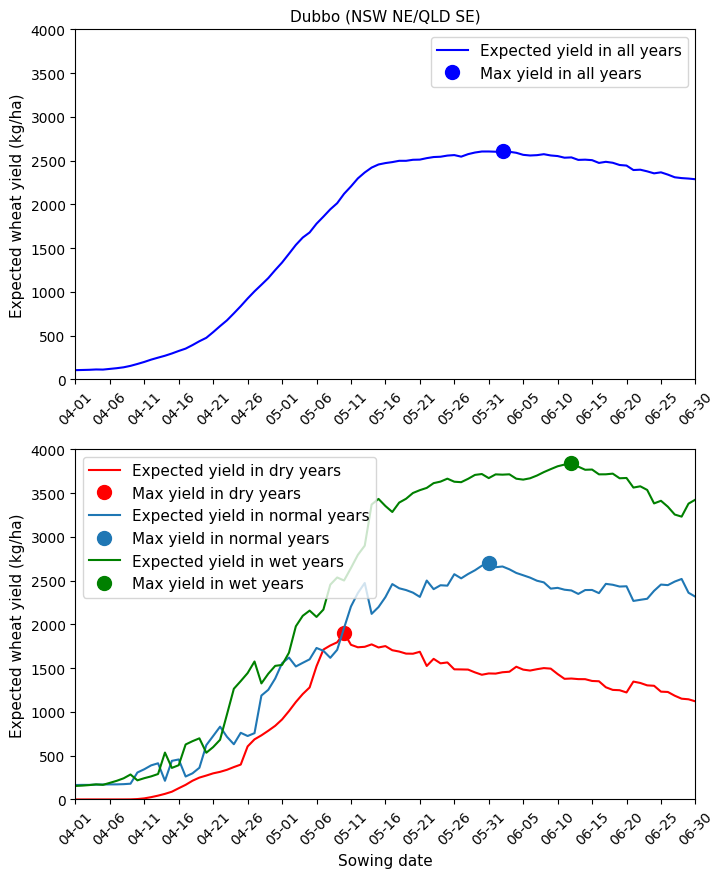

In [20]:
# Plotting the optimal sowing day based on yield
fig, axs = plt.subplots(2,1)
fig.set_size_inches(8, 10)
# All years
axs[0].plot(sd, Ys, c = 'b', linewidth=1.5)
axs[0].plot(sd.iloc[Ys.idxmax()], Ys.max(), 'o', c = 'b', markersize=10)     # Marking the optimal sowing date, 
axs[0].legend(['Expected yield in all years', 'Max yield in all years'], fontsize=11)
axs[0].set_title("Dubbo (NSW NE/QLD SE)", fontsize=11)
axs[0].set_ylim(0, 4000)
axs[0].set_xlim(sd.loc[91], sd.loc[181])
axs[0].set_xticks(sd.loc[np.arange(91, 182, 5)])
axs[0].tick_params(axis = 'x', labelrotation = 45, labelsize = 10)
axs[0].tick_params(axis = 'y', labelsize = 10)
axs[0].set_ylabel('Expected wheat yield (kg/ha)', fontsize=11)
# Dry years
axs[1].plot(sd, LYs, c = 'r', linewidth=1.5)
axs[1].plot(sd.iloc[LYs.idxmax()], LYs.max(), 'o', c = 'r', markersize=10)     # Marking the optimal sowing date, 
# Normal years
axs[1].plot(sd, NYs, c = 'tab:blue', linewidth=1.5)
axs[1].plot(sd.iloc[NYs.idxmax()], NYs.max(), 'o', c = 'tab:blue', markersize=10)     # Marking the optimal sowing date, 
# Wet years
axs[1].plot(sd, UYs, c = 'g', linewidth=1.5)
axs[1].plot(sd.iloc[UYs.idxmax()], UYs.max(), 'o', c = 'g', markersize=10)     # Marking the optimal sowing date, 
axs[1].legend(['Expected yield in dry years', 'Max yield in dry years',
           'Expected yield in normal years', 'Max yield in normal years',
           'Expected yield in wet years', 'Max yield in wet years'], fontsize=11)
axs[1].tick_params(axis = 'x', labelrotation = 45, labelsize = 10)
axs[1].tick_params(axis = 'y', labelsize = 10)
axs[1].set_ylabel('Expected wheat yield (kg/ha)', fontsize=11)
axs[1].set_ylim(0, 4000)
axs[1].set_xlim(sd.loc[91], sd.loc[181])
axs[1].set_xticks(sd.loc[np.arange(91, 182, 5)])
axs[1].set_xlabel('Sowing date', fontsize=11)
#axs[1].set_title("Dubbo (NSW NE/QLD SE)", fontsize=14)
fig.subplots_adjust(hspace=0.2)
print('The optimal sowing date at Dubbo in all years is:', sd.iloc[Ys.idxmax()])
print()
print('The optimal sowing date at Dubbo in dry years is:', sd.iloc[LYs.idxmax()])
print()
print('The optimal sowing date at Dubbo in normal years is:', sd.iloc[NYs.idxmax()])
print()
print('The optimal sowing date at Dubbo in wet years is:', sd.iloc[UYs.idxmax()])
print()
fig.savefig('OptSow_Dubbo_Yield.tiff')

The optimal sowing date at Dubbo in all years is: 05-31

The optimal sowing date at Dubbo in dry years is: 05-10

The optimal sowing date at Dubbo in normal years is: 05-31

The optimal sowing date at Dubbo in wet years is: 06-12



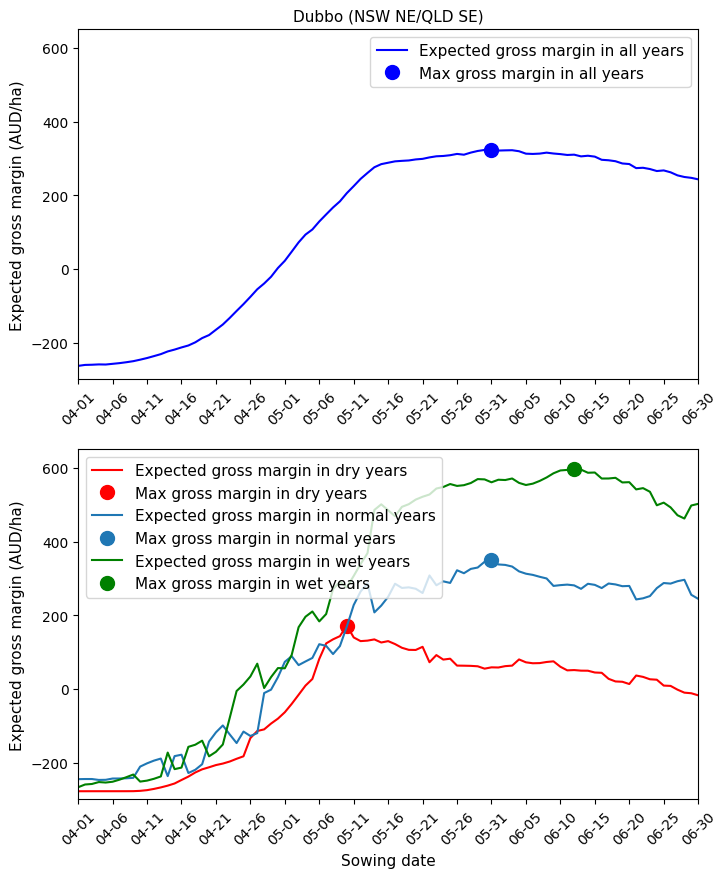

In [21]:
# Plotting the optimal sowing day based on gross margin
fig, axs = plt.subplots(2,1)
fig.set_size_inches(8, 10)
# All years
axs[0].plot(sd, GMs, c = 'b', linewidth=1.5)
axs[0].plot(sd.iloc[GMs.idxmax()], GMs.max(), 'o', c = 'b', markersize=10)     # Marking the optimal sowing date, 
axs[0].legend(['Expected gross margin in all years', 'Max gross margin in all years'], fontsize=11)
axs[0].set_title("Dubbo (NSW NE/QLD SE)", fontsize=11)
axs[0].set_ylim(-300, 650)
axs[0].set_xlim(sd.loc[91], sd.loc[181])
axs[0].set_xticks(sd.loc[np.arange(91, 182, 5)])
axs[0].tick_params(axis = 'x', labelrotation = 45, labelsize = 10)
axs[0].tick_params(axis = 'y', labelsize = 10)
axs[0].set_ylabel('Expected gross margin (AUD/ha)', fontsize=11)
# Dry years
axs[1].plot(sd, GM_LYs, c = 'r', linewidth=1.5)
axs[1].plot(sd.iloc[GM_LYs.idxmax()], GM_LYs.max(), 'o', c = 'r', markersize=10)     # Marking the optimal sowing date, 
# Normal years
axs[1].plot(sd, GM_NYs, c = 'tab:blue', linewidth=1.5)
axs[1].plot(sd.iloc[GM_NYs.idxmax()], GM_NYs.max(), 'o', c = 'tab:blue', markersize=10)     # Marking the optimal sowing date, 
# Wet years
axs[1].plot(sd, GM_UYs, c = 'g', linewidth=1.5)
axs[1].plot(sd.iloc[GM_UYs.idxmax()], GM_UYs.max(), 'o', c = 'g', markersize=10)     # Marking the optimal sowing date, 
axs[1].legend(['Expected gross margin in dry years', 'Max gross margin in dry years',
           'Expected gross margin in normal years', 'Max gross margin in normal years',
           'Expected gross margin in wet years', 'Max gross margin in wet years'], fontsize=11)
axs[1].tick_params(axis = 'x', labelrotation = 45, labelsize = 10)
axs[1].tick_params(axis = 'y', labelsize = 10)
axs[1].set_ylabel('Expected gross margin (AUD/ha)', fontsize=11)
axs[1].set_ylim(-300, 650)
axs[1].set_xlim(sd.loc[91], sd.loc[181])
axs[1].set_xticks(sd.loc[np.arange(91, 182, 5)])
axs[1].set_xlabel('Sowing date', fontsize=11)
fig.subplots_adjust(hspace=0.2)
print('The optimal sowing date at Dubbo in all years is:', sd.iloc[GMs.idxmax()])
print()
print('The optimal sowing date at Dubbo in dry years is:', sd.iloc[GM_LYs.idxmax()])
print()
print('The optimal sowing date at Dubbo in normal years is:', sd.iloc[GM_NYs.idxmax()])
print()
print('The optimal sowing date at Dubbo in wet years is:', sd.iloc[GM_UYs.idxmax()])
print()
fig.savefig('OptSow_Dubbo_GM.tiff')

In [22]:
# Value of seasonal forecasting of seasonal precipitation tercile at the site
Vf_W = []                         # Value of the wet forecast
Vf_N = []                         # Value of the normal forecast
Vf_D = []                         # Value of the dry forecast
#
OptSow_W = []                     # Optimal sowing date with a wet forecast
OptSow_N = []                     # Optimal sowing date with a normal forecast
OptSow_D = []                     # Optimal sowing date with a dry forecast
for q in np.arange(1/3, 1, 0.01):
    # Wet forecast
    GMfw = q*GM_UYs + (1-q)*GM_NYs/2 + (1-q)*GM_LYs/2        # Expected gross margin with the wet forecast 
    Vfw = GMfw.max() - GMfw.iloc[GMs.idxmax()]
    Vf_W.append(Vfw)
    #OptSow_W.append(sd.iloc[GMfw.idxmax()])                 # We cannot use this because later plot won't understand order in the date strings
    OptSow_W.append(GMfw.idxmax()+91)
    # Normal forecast
    GMfn = (1-q)*GM_UYs/2 + q*GM_NYs + (1-q)*GM_LYs/2        # Expected gross margin with the normal forecast 
    Vfn = GMfn.max() - GMfn.iloc[GMs.idxmax()]
    Vf_N.append(Vfn)
    #OptSow_N.append(sd.iloc[GMfn.idxmax()])
    OptSow_N.append(GMfn.idxmax()+91)
    # Dry forecast
    GMfd = (1-q)*GM_UYs/2 + (1-q)*GM_NYs/2 + q*GM_LYs        # Expected gross margin with the dry forecast 
    Vfd = GMfd.max() - GMfd.iloc[GMs.idxmax()]
    Vf_D.append(Vfd)
    #OptSow_D.append(sd.iloc[GMfd.idxmax()])
    OptSow_D.append(GMfd.idxmax()+91)
#

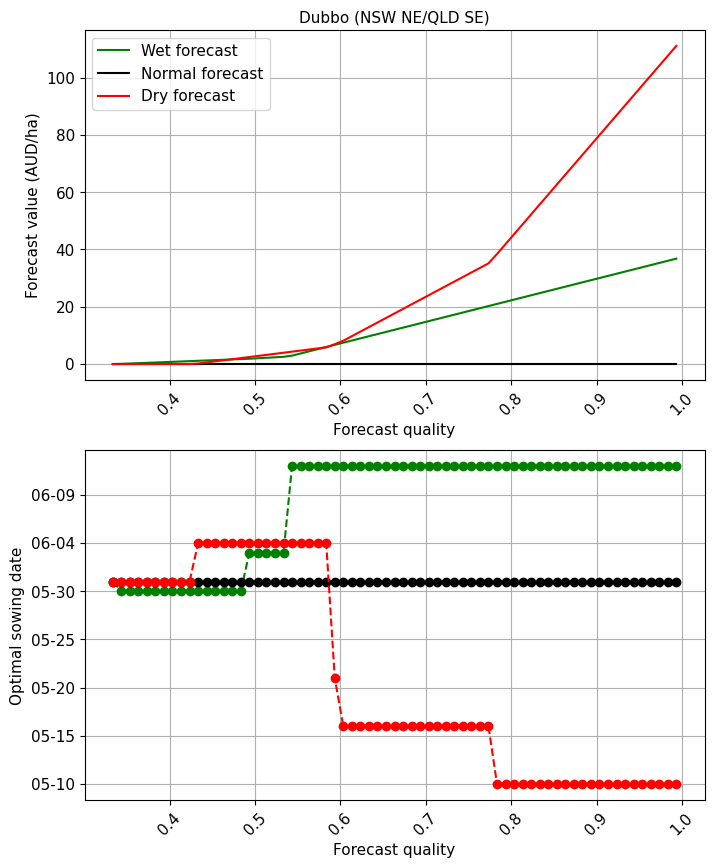

In [24]:
# Plotting forecast values
fig, axs = plt.subplots(2,1)
fig.set_size_inches(8, 10)
q = np.arange(1/3, 1, 0.01)
axs[0].plot(q, Vf_W, c = 'g', linewidth=1.5)            # Wet years
axs[0].plot(q, Vf_N, c = 'k', linewidth=1.5)     # Normal years
axs[0].plot(q, Vf_D, c = 'r', linewidth=1.5)            # Dry years
axs[0].set_title("Dubbo (NSW NE/QLD SE)", fontsize=11)
axs[0].legend(['Wet forecast', 'Normal forecast', 'Dry forecast'], fontsize=11)
axs[0].tick_params(axis = 'x', labelrotation = 45, labelsize = 11)
axs[0].tick_params(axis = 'y', labelsize = 11)
axs[0].set_ylabel('Forecast value (AUD/ha)', fontsize=11)
axs[0].set_xlabel('Forecast quality', fontsize=11)
axs[0].grid(True)
#
# Plotting optimal sowing date
axs[1].plot(q, OptSow_W, '--o', c = 'g', linewidth=1.5)                  # Wet years
#axs[1].plot(q, OptSow_N, '--o', c = 'tab:blue', linewidth=2)           # Normal years
axs[1].plot(q, OptSow_N, '--o', c = 'k', linewidth=1.5)           # Normal years
axs[1].plot(q, OptSow_D, '--o', c = 'r', linewidth=1.5)                  # Dry years
axs[1].set_yticks(np.arange(130, 161, 5))
axs[1].set_yticklabels(sd.loc[np.arange(130, 161, 5)])
axs[1].tick_params(axis = 'x', labelrotation = 45, labelsize = 11)
axs[1].tick_params(axis = 'y', labelsize = 11)
axs[1].set_ylabel('Optimal sowing date', fontsize=11)
axs[1].set_xlabel('Forecast quality', fontsize=11)
axs[1].grid(True)
#axs[1].set_ylim(-300, 650)
#axs[1].set_xlim(sd.loc[91], sd.loc[181])
fig.savefig('ForecastValues.tiff')

## Conducting analysis at all sites

In [26]:
# Using SILO API to get rainfall data at all the stations
api_url = 'https://www.longpaddock.qld.gov.au/cgi-bin/silo'
All_Station_Rain = pd.DataFrame({})
All_Station_Rain['Year'] = Year
for i, row in dfS.iterrows():
    params = {
        'format': 'csv',
        'station': str(dfS.loc[i, "Weather Station"]),
        'start': '19570101',
        'finish': '20131231',
        'username': 'duc-anh.an-vo@usq.edu.au',
        'comment': 'R'
    }    
    url = api_url + '/PatchedPointDataset.php?' + urllib.parse.urlencode(params)
    with urllib.request.urlopen(url) as remote:
        data = remote.read()
    datafile = io.StringIO(data.decode())       # Instantiate the file-like object
    Station_Data = pd.read_csv(datafile)
    All_Station_Rain[row.Sites] = Station_Data.daily_rain
All_Station_Rain

,Year,Goondiwindi,Meandarra,Dalby,Roma,Emerald,Condobolin,Wellington,Dubbo,Gilgandra,...,Merredin,SouthernCross,WonganHills,Bencubbin,Badgingarra,Dalwallinu,Carnamah,Morawa,Geraldton,Mullewa
0,1957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1957,0.0,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1957,0.0,4.2,0.0,0.0,0.0,0.0,2.0,0.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1957,11.9,1.8,0.0,0.0,0.0,10.2,2.0,1.0,5.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20814,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20815,2013,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20816,2013,0.0,0.0,0.0,0.0,4.3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20817,2013,0.0,0.0,0.0,0.0,1.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Set years as the row index
All_Station_Rain = All_Station_Rain.set_index('Year')
All_Station_Rain

,Goondiwindi,Meandarra,Dalby,Roma,Emerald,Condobolin,Wellington,Dubbo,Gilgandra,Nyngan,...,Merredin,SouthernCross,WonganHills,Bencubbin,Badgingarra,Dalwallinu,Carnamah,Morawa,Geraldton,Mullewa
Year,,,,,,,,,,,,,,,,,,,,,
1957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1957,0.0,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1957,0.0,4.2,0.0,0.0,0.0,0.0,2.0,0.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1957,11.9,1.8,0.0,0.0,0.0,10.2,2.0,1.0,5.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.8,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,0.0,0.0,0.0,0.0,4.3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Constructing expected yield and gross margin dataframes
dfYs = pd.DataFrame({})                                           # Dataframe for average yield over all years for all sites
dfLYs = pd.DataFrame({})                                          # Dataframe for average yield over dry years for all sites
dfNYs = pd.DataFrame({})                                          # Dataframe for average yield over normal years for all sites
dfUYs = pd.DataFrame({})                                          # Dataframe for average yield over wet years for all sites
dfYs["SowingDate"] = sd
dfLYs["SowingDate"] = sd
dfNYs["SowingDate"] = sd
dfUYs["SowingDate"] = sd
# Gross margins
dfGMs = pd.DataFrame({})                                           # Dataframe for expected gross margin over all years for all sites
dfLGMs = pd.DataFrame({})                                          # Dataframe for expected gross margin over dry years for all sites
dfNGMs = pd.DataFrame({})                                          # Dataframe for expected gross margin over normal years for all sites
dfUGMs = pd.DataFrame({})                                          # Dataframe for expected gross margin over wet years for all sites
dfGMs["SowingDate"] = sd
dfLGMs["SowingDate"] = sd
dfNGMs["SowingDate"] = sd
dfUGMs["SowingDate"] = sd
#
for ix, row in dfS.iterrows():                                    # Looping over all sites
    dfY_site = dfY.loc[dfS.loc[ix, "Weather Station"], :]         # Extract wheat yield dataframe at a site
    dfY0_site = dfY_site[dfY_site["post_head"] == '0']            # For current genotype
    dfY0_n0_site = dfY0_site[dfY0_site["nitrogen"] == 0]          # No added nitrogen
    dfY0_n0_site = dfY0_n0_site.set_index('Year')                 # Set years as the row index
    # Construct a dataframe of yields across the sowing window for all simulated years at a site
    dfYield = pd.DataFrame({})
    dfN = pd.DataFrame({})
    # Construct a seasonal rainfall dataframe based on each sowing date from 1957 to 2013 for a site
    SR = pd.DataFrame({})
    Station_Rain = All_Station_Rain[row.Sites]               
    for i in np.arange(1957, 2014, 1):
        dfYield[i] = dfY0_n0_site.loc[i, 'yield'].array                                                             # Yields
        dfN[i] = (dfY0_n0_site.loc[i, 'nsowing'] + dfY_Site.loc[i, 'n30'] + dfY_Site.loc[i, 'n37']).array           # Nitrogens
        Yearly_Rain = Station_Rain[i]
        seasonal_Rain = []
        for j in np.arange(90, 181, 1):
            #seasonal_R = Yearly_Rain[j:j+150].sum()                           # Seasonal rainfall estimated from the sowing date to 150 days after sowing
            seasonal_R = Yearly_Rain.iloc[j:j+150].sum()                           # Seasonal rainfall estimated from the sowing date to 150 days after sowing
            seasonal_Rain.append(seasonal_R)
        SR[i] = seasonal_Rain
    # Construct expected yields and gross margin in all years and in the three climatic conditions across the sowing window for a site
    Ys = []        # Yields in all years
    LYs = []       # Yields in dry years
    NYs = []       # Yields in normal years
    UYs = []       # Yields in wet years
    #
    GMs = []       # Gross margin in all years
    GM_LYs = []    # Gross margin in dry years
    GM_NYs = []    # Gross margin in normal years
    GM_UYs = []    # Gross margin in wet years
    for i, _ in SR.iterrows():
        # Expected yield in all years
        Y = dfYield.loc[i,:].mean()
        # Expected gross margin in all years
        GM = (dfYield.loc[i,:]*0.001*row['Wheat price ($/t)']-row['Input cost without N ($/ha)'] - dfN.loc[i,:]*564/460).mean()                        # For gross margin estimation, please refer to An-Vo et al. (2018)
        # Construct masks for the three climatic conditions
        LQ = np.quantile(SR.loc[i,:].array, 1/3)          # Bottom tercile
        UQ = np.quantile(SR.loc[i,:].array, 2/3)          # Top tercile
        #
        mask_L = SR.loc[i,:].lt(LQ)                       # Mask for low yields
        mask_U = SR.loc[i,:].gt(UQ)                       # Mask for high yields
        mask_N = SR.loc[i,:].ge(LQ) & SR.loc[i,:].le(UQ)  # Mask for normal yields
        # Expected yields in the 3 climatic conditions
        LY = dfYield.loc[i, mask_L].mean()                # Expected yield in dry years
        UY = dfYield.loc[i, mask_U].mean()                # Expected yield in wet years
        NY = dfYield.loc[i, mask_N].mean()                # Expected yield in normal years
        # Expected gross margins in the 3 climatic conditions
        GM_LY = (dfYield.loc[i, mask_L]*0.001*row['Wheat price ($/t)']-row['Input cost without N ($/ha)'] - dfN.loc[i, mask_L]*564/460).mean()
        GM_UY = (dfYield.loc[i, mask_U]*0.001*row['Wheat price ($/t)']-row['Input cost without N ($/ha)'] - dfN.loc[i, mask_U]*564/460).mean()
        GM_NY = (dfYield.loc[i, mask_N]*0.001*row['Wheat price ($/t)']-row['Input cost without N ($/ha)'] - dfN.loc[i, mask_N]*564/460).mean()
        #
        Ys.append(Y)
        LYs.append(LY)
        NYs.append(NY)
        UYs.append(UY)
        #
        GMs.append(GM)
        GM_LYs.append(GM_LY)
        GM_NYs.append(GM_NY)
        GM_UYs.append(GM_UY)
    #
    dfYs[row.Sites] = Ys
    dfLYs[row.Sites] = LYs
    dfNYs[row.Sites] = NYs
    dfUYs[row.Sites] = UYs
    #
    dfGMs[row.Sites] = GMs
    dfLGMs[row.Sites] = GM_LYs
    dfNGMs[row.Sites] = GM_NYs
    dfUGMs[row.Sites] = GM_UYs

In [47]:
# Long-term expected yields at all sites
dfYs

,SowingDate,Goondiwindi,Meandarra,Dalby,Roma,Emerald,Condobolin,Wellington,Dubbo,Gilgandra,...,Merredin,SouthernCross,WonganHills,Bencubbin,Badgingarra,Dalwallinu,Carnamah,Morawa,Geraldton,Mullewa
91,04-01,781.573992,139.818817,236.585269,97.398531,1449.639345,7.814488,0.801496,106.331435,12.209910,...,345.834066,97.299416,1980.644771,973.183560,1747.213338,1502.485469,1481.471408,1170.757502,1331.950038,576.390363
92,04-02,790.111557,143.724182,236.633079,90.102301,1467.316704,12.111088,1.193390,108.191487,12.283829,...,345.193828,97.077461,2009.645088,976.230360,1780.550457,1536.421567,1519.042722,1192.011985,1362.637265,584.875915
93,04-03,805.749854,141.026012,235.309355,86.744517,1466.935310,17.193603,1.801191,110.228435,12.361090,...,351.385671,97.524135,2048.098812,996.994402,1811.430484,1564.129520,1540.736384,1216.580484,1392.408947,590.384526
94,04-04,812.413940,146.828312,237.636292,82.539252,1464.448218,21.645451,2.808448,114.031288,11.323906,...,355.852155,98.562029,2078.104876,1029.064377,1838.107833,1607.373818,1599.103927,1256.442817,1430.123128,598.909489
95,04-05,829.868294,150.067643,239.007814,80.360456,1464.965039,27.077408,5.084626,112.700451,15.956654,...,365.687590,100.565296,2116.492487,1050.395282,1869.693516,1661.130571,1638.871479,1279.327816,1463.173124,608.131699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,06-26,1622.406356,1378.035863,2089.908352,668.714312,688.483730,1516.357753,2486.561554,2341.073046,2020.558027,...,756.888099,335.109147,1171.571071,691.766486,1190.114028,880.206204,837.838528,588.966374,1377.355789,235.313059
178,06-27,1616.666195,1369.649585,2089.416272,671.850211,671.148947,1491.804784,2452.645027,2310.574643,1994.646216,...,742.524485,329.125196,1150.278108,666.483868,1159.159166,867.048175,806.365133,572.482001,1382.594365,230.540361
179,06-28,1626.619728,1371.076469,2101.855049,672.910715,649.027823,1483.292401,2449.875811,2301.182943,1987.058489,...,716.429787,323.531412,1126.837718,645.727713,1124.309777,834.440611,787.796453,551.790619,1354.393250,224.493204
180,06-29,1609.721788,1358.496625,2095.061385,684.973602,629.700217,1466.009792,2410.199845,2295.913983,1963.118823,...,706.964875,321.987050,1092.025699,634.637417,1116.201986,807.585409,761.324544,541.294236,1290.594401,217.253325


In [48]:
# Long-term expected yields at all sites in a dry seasonal condition
dfLYs

,SowingDate,Goondiwindi,Meandarra,Dalby,Roma,Emerald,Condobolin,Wellington,Dubbo,Gilgandra,...,Merredin,SouthernCross,WonganHills,Bencubbin,Badgingarra,Dalwallinu,Carnamah,Morawa,Geraldton,Mullewa
91,04-01,368.015169,15.199834,0.841865,8.563296,1382.432550,20.450469,0.048454,0.000209,25.761996,...,284.074448,94.786724,1644.743789,962.014454,1767.788420,1226.606934,1341.663161,906.125304,1167.922738,523.501716
92,04-02,363.581129,35.352385,152.105710,6.797760,1383.401165,33.244853,0.110085,0.000274,25.596522,...,292.651174,99.697034,1648.537367,978.424169,1817.474735,1258.529969,1398.317894,894.180806,1219.608629,538.985851
93,04-03,335.660125,15.825481,141.098267,0.004566,1290.758711,48.021928,0.243563,0.181434,24.514436,...,309.546845,103.999131,1698.132209,990.997927,1839.487371,1300.636972,1426.276837,916.016739,1232.149445,545.914779
94,04-04,319.950250,15.670801,131.716757,4.223028,1420.395306,60.402181,0.498608,0.183175,16.909301,...,321.693127,111.701017,1718.570425,1011.884845,1885.231583,1338.627760,1483.144208,944.962038,1295.170424,556.830462
95,04-05,274.289157,16.009987,0.765027,3.668903,1390.310740,75.414127,0.792338,0.189778,15.651716,...,333.642363,119.779539,1750.861676,1035.055831,1924.010523,1433.132753,1537.230530,970.681677,1319.070947,549.093422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,06-26,793.471126,820.906359,1319.211721,361.208404,435.772499,708.531403,1324.054829,1228.366347,1095.772800,...,430.304664,248.887474,833.458133,366.870071,1259.260301,646.690355,640.073836,382.243512,1257.313537,242.811567
178,06-27,802.594213,830.646408,1218.225183,358.816886,411.204923,688.852356,1302.417537,1185.591160,1080.143839,...,418.793326,247.975267,801.131860,364.415958,1116.803422,589.272785,609.087302,369.534627,1190.157071,239.486404
179,06-28,808.819683,832.424670,1354.044480,377.177625,391.198179,686.055970,1297.996143,1151.426890,1063.822867,...,407.438667,244.593569,771.940369,401.205753,1065.359736,575.197694,540.819170,350.424050,1110.415728,233.725160
180,06-29,805.004690,823.274502,1370.091840,384.890703,370.462033,646.072884,1297.115458,1144.611480,1015.308069,...,424.758185,239.856583,749.310785,352.261805,992.877762,556.079513,530.734939,347.044903,1057.659270,223.834457


In [49]:
# Long-term expected yields at all sites in a normal seasonal condition
dfNYs

,SowingDate,Goondiwindi,Meandarra,Dalby,Roma,Emerald,Condobolin,Wellington,Dubbo,Gilgandra,...,Merredin,SouthernCross,WonganHills,Bencubbin,Badgingarra,Dalwallinu,Carnamah,Morawa,Geraldton,Mullewa
91,04-01,705.620058,22.138726,165.088239,115.054327,1494.265696,2.884979,0.019615,164.806096,0.004471,...,115.918348,26.458606,2055.795785,1024.675576,1769.367362,1648.393682,1500.552113,1225.893048,1473.536846,611.634735
92,04-02,710.178857,12.143309,7.252334,113.655251,1493.741046,2.989414,0.091604,166.408316,0.029707,...,206.412775,22.633664,2100.627371,1024.670106,1827.217896,1760.540002,1543.281854,1245.482018,1481.642108,625.488421
93,04-03,758.802464,49.995879,6.088094,119.541382,1562.932178,3.405008,0.289973,166.392468,0.175689,...,204.559688,19.254794,2150.684215,1054.434098,1842.913681,1784.248425,1579.073368,1243.063280,1540.304996,622.353684
94,04-04,803.893231,75.982906,5.062742,112.142232,1515.119889,4.312989,0.615478,169.555328,0.561566,...,205.709725,16.023229,2178.606307,1095.876128,1816.685272,1819.442112,1622.372846,1264.309584,1529.854737,636.968422
95,04-05,738.796776,97.638860,122.496117,111.960622,1576.807695,5.494285,1.692981,170.946546,1.169029,...,122.266015,13.670106,2239.825264,1130.083104,1896.227363,1819.601053,1662.736537,1289.695246,1571.211579,676.120001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,06-26,1907.522404,1257.960757,1987.102125,627.602719,563.131889,1410.866372,2610.048422,2449.382436,2287.312431,...,746.814906,376.956007,1107.810541,822.322763,1160.795142,816.178178,851.228868,606.750083,1518.669831,244.598014
178,06-27,1953.399162,1240.387558,2098.735316,635.047028,555.401137,1271.918390,2403.174388,2490.033575,2316.847379,...,743.695412,364.388072,1137.950663,741.222222,1215.734403,857.929003,894.279631,591.078518,1543.587865,211.916467
179,06-28,1869.636013,1244.841693,1992.583061,634.793613,549.216534,1390.825922,2505.725392,2519.956188,2327.394995,...,712.561042,377.665274,1092.721812,657.106035,1181.593236,824.413012,906.202930,576.675062,1556.531490,205.809399
180,06-29,1749.091528,1232.084223,1967.922123,647.417355,535.038709,1394.698923,2502.314868,2362.437849,2329.221622,...,715.133250,374.481283,1055.107600,738.378058,1209.841572,792.292103,844.076383,549.794787,1467.688248,172.617886


In [50]:
# Long-term expected yields at all sites in a wet seasonal condition
dfUYs

,SowingDate,Goondiwindi,Meandarra,Dalby,Roma,Emerald,Condobolin,Wellington,Dubbo,Gilgandra,...,Merredin,SouthernCross,WonganHills,Bencubbin,Badgingarra,Dalwallinu,Carnamah,Morawa,Geraldton,Mullewa
91,04-01,1271.086749,382.117891,543.825702,168.577970,1472.219788,0.108016,2.336418,154.188000,10.863264,...,637.509401,170.652919,2241.394738,932.860650,1704.484233,1632.455790,1602.198950,1380.254154,1354.390530,594.034639
92,04-02,1296.574685,383.676852,550.541191,149.853892,1524.807902,0.098995,3.378481,158.165870,11.225259,...,536.517535,168.901684,2279.770526,925.596805,1696.958739,1590.194731,1615.528417,1436.373131,1386.661057,590.153473
93,04-03,1322.786972,357.256677,558.741705,140.687605,1547.115041,0.153872,4.870036,164.111402,12.393146,...,540.050481,169.318479,2295.480012,945.551181,1751.890401,1607.503163,1616.858948,1490.661433,1388.553687,602.885116
94,04-04,1313.398338,348.831227,576.129376,131.252495,1457.829460,0.221182,7.311258,172.355361,16.500851,...,540.153613,167.961840,2337.137895,979.432156,1812.406645,1664.051582,1691.794726,1560.056830,1465.344221,602.929584
95,04-05,1476.518948,336.554082,593.762299,125.451844,1427.776680,0.323811,12.768557,166.965030,31.049216,...,641.154391,168.246243,2358.790521,986.046911,1788.842660,1730.657909,1716.647371,1577.606526,1499.236847,599.181674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,06-26,2166.225537,2055.240473,2963.411208,1017.331814,1066.546801,2429.675483,3525.581410,3345.470354,2678.588850,...,1093.544726,379.483960,1573.444538,886.106624,1150.286640,1177.750079,1022.212881,777.905526,1356.083999,218.529597
178,06-27,2094.005211,2037.914790,2951.288317,1021.686718,1046.840780,2514.643606,3652.343156,3256.099195,2586.947431,...,1065.084717,375.012249,1511.751799,893.813425,1144.939675,1153.942737,915.728465,756.832858,1414.038158,240.218213
179,06-28,2201.403486,2035.963044,2958.937607,1006.760906,1006.668756,2372.995311,3545.905898,3232.165751,2569.957605,...,1029.289653,348.335393,1515.850972,878.871350,1125.976360,1103.711127,916.367260,736.694838,1396.232531,233.945053
180,06-29,2275.069145,2020.131150,2947.170191,1022.612750,983.599909,2357.257568,3431.169211,3380.692621,2544.826779,...,981.003192,351.623284,1471.658711,813.272388,1145.886624,1074.384610,909.162309,716.371972,1346.435684,255.307631


In [51]:
# Long-term expected gross margins at all sites 
dfGMs

,SowingDate,Goondiwindi,Meandarra,Dalby,Roma,Emerald,Condobolin,Wellington,Dubbo,Gilgandra,...,Merredin,SouthernCross,WonganHills,Bencubbin,Badgingarra,Dalwallinu,Carnamah,Morawa,Geraldton,Mullewa
91,04-01,-163.749234,-316.486966,-354.760898,-276.297784,-24.569957,-290.291776,-285.471145,-263.152615,-285.553538,...,-181.522529,-271.408880,244.613332,-16.529612,182.987433,118.379276,112.350092,30.632335,73.025972,-150.207961
92,04-02,-159.566264,-313.406459,-352.598490,-275.875961,-18.070297,-287.135342,-283.228020,-260.558893,-283.384915,...,-179.539881,-269.316225,254.420445,-13.577273,193.939462,129.489436,124.382378,38.373294,83.247742,-145.825232
93,04-03,-155.844349,-314.048624,-352.913536,-276.671755,-18.164120,-285.946033,-283.085187,-260.074099,-283.366527,...,-177.911427,-269.198750,264.572228,-8.116330,202.091790,136.804335,130.087811,44.834809,91.077695,-144.376467
94,04-04,-154.258297,-312.667676,-352.359725,-277.668403,-18.775944,-284.904301,-282.848482,-259.169020,-283.613377,...,-176.736741,-268.925784,272.493829,0.318073,209.134610,148.220830,145.438475,55.318603,100.996524,-142.134402
95,04-05,-150.104161,-311.896716,-352.033303,-278.184778,-18.648806,-283.633223,-282.313580,-259.485759,-282.510783,...,-174.150022,-268.398924,282.628159,5.928101,217.473230,162.412613,155.897341,61.337358,109.688674,-139.708961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,06-26,29.915779,-28.244398,79.876906,-147.349033,-218.267327,56.254259,292.229379,262.262799,185.980225,...,-79.868407,-215.318011,24.564786,-96.995391,29.460126,-52.355539,-63.378444,-128.831821,78.514595,-246.364382
178,06-27,27.474106,-31.315847,78.684276,-147.681340,-223.607199,49.433349,283.183481,253.928664,178.737699,...,-84.721552,-217.967305,17.867928,-104.720235,20.212528,-56.904774,-72.731462,-134.242726,78.816826,-248.695116
179,06-28,27.692017,-33.127279,79.493676,-149.581030,-231.200025,45.290422,280.381685,249.542410,174.780790,...,-93.735488,-221.589500,9.528636,-112.330133,8.861260,-67.664200,-79.766055,-141.835589,69.248903,-252.436548
180,06-29,22.594792,-37.196796,76.801269,-147.797641,-237.030131,40.170776,269.982318,247.212883,168.007635,...,-97.300274,-223.071182,-0.737252,-116.322396,5.645288,-75.829489,-87.803682,-145.671653,51.394291,-255.416151


In [52]:
# Long-term expected gross margins at all sites in a dry seasonal condition
dfLGMs

,SowingDate,Goondiwindi,Meandarra,Dalby,Roma,Emerald,Condobolin,Wellington,Dubbo,Gilgandra,...,Merredin,SouthernCross,WonganHills,Bencubbin,Badgingarra,Dalwallinu,Carnamah,Morawa,Geraldton,Mullewa
91,04-01,-261.100719,-345.070769,-409.792314,-296.276220,-36.800769,-283.032897,-278.119506,-277.704298,-274.799537,...,-193.463249,-270.994204,157.010987,-15.165027,189.494770,49.849402,79.882583,-34.663874,34.188852,-166.268705
92,04-02,-262.156021,-337.047917,-370.564974,-293.468107,-36.562490,-276.812466,-278.105022,-277.704283,-274.838920,...,-191.207570,-269.702792,158.012492,-10.849272,209.065046,58.277083,94.782778,-37.805276,47.782241,-162.196378
93,04-03,-268.801220,-341.695321,-373.184745,-295.078094,-59.352533,-273.354631,-278.073655,-277.661167,-275.096457,...,-186.764008,-268.571341,171.105530,-7.542374,214.876382,69.393332,102.135980,-32.062426,50.721971,-160.374070
94,04-04,-272.540170,-341.732134,-375.417544,-294.078319,-30.688476,-273.684196,-278.013720,-277.660752,-276.906479,...,-186.796081,-269.772289,173.274675,-5.275659,223.726310,76.196356,113.865554,-27.676357,64.428448,-157.503245
95,04-05,-283.407510,-341.651408,-406.584056,-294.209646,-38.089279,-270.171401,-277.944693,-277.659181,-277.205784,...,-183.653432,-267.647638,181.799565,0.818311,233.963950,101.145674,128.090256,-20.912092,70.714286,-159.538087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,06-26,-166.295291,-153.312616,-105.699922,-215.925874,-276.132231,-122.021958,33.021992,8.193754,-20.136966,...,-167.910880,-240.145340,-66.848060,-184.594178,45.563713,-109.701664,-114.315043,-175.671329,57.698632,-240.090215
178,06-27,-164.123996,-154.221029,-129.734718,-216.492663,-282.175854,-126.626855,27.937229,-1.986741,-23.856659,...,-170.938362,-240.385251,-78.608740,-185.239610,11.181641,-124.859902,-122.464502,-179.013766,40.036481,-240.964732
179,06-28,-165.868879,-153.797803,-97.409725,-215.367713,-293.550603,-127.281210,26.898201,-10.117837,-27.741050,...,-173.924637,-241.274637,-86.315294,-175.563894,-2.399492,-128.575726,-137.192476,-184.039848,15.837964,-242.479940
180,06-29,-166.776847,-155.975543,-93.590453,-213.539714,-298.651695,-136.637252,26.691240,-11.739905,-39.287572,...,-169.369604,-245.747009,-95.516049,-191.662697,-24.761278,-133.622926,-139.844629,-185.466321,1.963015,-245.081195


In [53]:
# Long-term expected gross margins at all sites in a normal seasonal condition
dfNGMs

,SowingDate,Goondiwindi,Meandarra,Dalby,Roma,Emerald,Condobolin,Wellington,Dubbo,Gilgandra,...,Merredin,SouthernCross,WonganHills,Bencubbin,Badgingarra,Dalwallinu,Carnamah,Morawa,Geraldton,Mullewa
91,04-01,-177.524211,-340.192768,-364.248587,-264.584756,-9.289815,-287.143222,-278.126283,-244.933586,-280.929828,...,-247.367937,-288.964499,259.075625,-1.911696,189.911611,151.521470,108.764199,42.981954,104.885728,-136.636632
92,04-02,-173.212672,-342.571677,-401.813533,-264.916337,-6.192334,-287.118784,-278.109365,-244.552258,-280.923822,...,-217.114813,-283.517369,280.590798,1.313409,201.957607,187.581188,126.455210,51.360398,110.243957,-129.766568
93,04-03,-161.640254,-333.562766,-402.090622,-263.521324,10.828684,-287.021535,-278.062749,-244.556030,-280.889079,...,-217.602175,-284.406012,293.805804,9.141339,206.101294,193.840211,135.868378,50.724270,126.317605,-130.591004
94,04-04,-154.135196,-330.604398,-405.561200,-268.501467,-0.933139,-283.582523,-277.986255,-247.029814,-280.797240,...,-214.073171,-285.255914,301.177237,20.040593,199.176994,206.357889,147.256141,56.312048,129.376968,-129.973873
95,04-05,-166.401608,-325.450281,-377.612057,-268.544509,14.242062,-283.306099,-277.733042,-246.698704,-280.652664,...,-236.018867,-285.874785,317.339041,29.037028,220.176106,206.399850,157.871792,62.988477,140.253817,-119.677007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,06-26,102.075458,-58.973303,59.711084,-159.243510,-244.801821,26.191701,312.644674,285.889404,244.090198,...,-81.442142,-200.010227,12.034065,-61.583576,26.022000,-74.636513,-58.781270,-126.305735,110.302614,-246.073468
178,06-27,109.767582,-63.155725,83.053239,-160.705754,-249.930130,-9.548671,264.029276,292.337831,247.892971,...,-88.715658,-206.542138,16.764513,-89.366107,37.299420,-66.840839,-47.458919,-136.880446,116.856057,-254.668715
179,06-28,86.605408,-71.775274,54.562457,-160.765813,-251.451543,11.822602,281.675673,296.232868,247.176759,...,-96.903997,-203.050234,8.050641,-111.488664,28.286152,-75.689061,-54.002725,-145.508372,123.486775,-256.274874
180,06-29,57.915820,-78.038097,48.693154,-157.773986,-254.939288,12.728884,280.874200,255.516959,244.384952,...,-99.454051,-200.661079,-1.879511,-86.887578,32.517168,-87.395526,-70.342007,-149.512667,100.121002,-265.004242


In [54]:
# Long-term expected gross margins at all sites in a wet seasonal condition
dfUGMs

,SowingDate,Goondiwindi,Meandarra,Dalby,Roma,Emerald,Condobolin,Wellington,Dubbo,Gilgandra,...,Merredin,SouthernCross,WonganHills,Bencubbin,Badgingarra,Dalwallinu,Carnamah,Morawa,Geraldton,Mullewa
91,04-01,-52.622773,-264.197361,-290.241794,-268.032376,-27.619287,-300.699209,-300.167647,-266.819961,-300.931248,...,-103.736400,-254.267939,317.753382,-32.512111,169.555920,153.766955,148.403496,83.578925,80.003336,-147.718547
92,04-02,-43.330099,-260.599783,-285.416963,-269.243438,-11.456066,-297.474776,-293.469672,-259.420139,-294.392004,...,-130.297261,-254.728514,324.658046,-31.195958,170.795734,142.610036,151.909145,101.564760,91.717030,-145.512749
93,04-03,-37.091575,-266.887785,-283.465241,-271.415848,-5.968510,-297.461935,-293.119157,-258.005102,-294.114047,...,-129.368096,-254.618897,328.805350,-25.947957,185.297693,147.179462,152.259075,115.842584,92.214791,-142.164327
94,04-04,-36.099525,-265.666497,-276.100431,-270.425424,-24.706218,-297.446184,-292.545470,-252.816495,-293.136413,...,-129.340973,-251.749148,343.029576,-13.810716,204.500526,162.108245,175.193729,137.320118,109.184157,-138.926087
95,04-05,-0.503364,-268.588458,-271.903795,-271.800179,-32.099202,-297.422169,-291.263005,-254.099394,-289.673902,...,-102.777768,-251.674350,348.745869,-12.071035,198.279634,179.692315,181.729975,141.935688,118.097918,-139.911787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,06-26,153.967170,127.552724,285.619556,-66.877715,-133.867931,264.593033,531.021471,492.705239,333.987442,...,9.747801,-205.798465,128.508351,-44.808420,16.794666,27.271559,-17.039019,-84.518398,67.542540,-252.929462
178,06-27,136.778732,123.429212,282.734308,-65.845602,-138.715612,284.475574,557.583937,471.434904,312.176784,...,5.489363,-206.974524,115.448013,-39.554987,12.156523,20.986420,-48.270965,-86.833965,79.557940,-250.451901
179,06-28,162.339522,126.191241,281.328295,-72.609565,-148.597930,251.329873,532.571181,462.512199,304.906661,...,-10.377828,-220.443627,106.850561,-49.937842,0.697118,1.272186,-48.102962,-93.205779,68.421970,-258.554831
180,06-29,176.645404,122.423250,275.301105,-72.079222,-157.499411,244.420697,502.381515,497.861594,298.925524,...,-23.077167,-222.805456,95.183803,-70.416913,9.179973,-6.470014,-53.224409,-103.928268,52.098855,-256.163017


In [55]:
# Optimal sowing dates based on yields and maximum yields
OptSow_Y = []                                                         # Optimal sowing dates for all sites in all years
OptSow_Y_D = []                                                       # Optimal sowing dates for all sites in dry years
OptSow_Y_N = []                                                       # Optimal sowing dates for all sites in normal years
OptSow_Y_W = []                                                       # Optimal sowing dates for all sites in wet years
# Optimal sowing dates in number for plotting
OS_Y = []                                                             # All years
OS_Y_D = []                                                           # Dry condition
OS_Y_N = []                                                           # Normal condition
OS_Y_W = []                                                           # Wet condition
#
MaxY = []                                                           # Maximum yield at each site in all years
MaxY_D = []                                                         # Maximum yield at each site in dry years
MaxY_N = []                                                         # Maximum yield at each site in normal years
MaxY_W = []                                                         # Maximum yield at each site in wet years
# Optimal sowing dates based on gross margins and maximum gross margin
OptSow_GM = []                                                         # Optimal sowing dates for all sites in all years 
OptSow_GM_D = []                                                       # Optimal sowing dates for all sites in dry years
OptSow_GM_N = []                                                       # Optimal sowing dates for all sites in normal years
OptSow_GM_W = []                                                       # Optimal sowing dates for all sites in wet years
# Optimal sowing dates in number for plotting
OS_GM = []                                                             # All years
OS_GM_D = []                                                           # Dry condition
OS_GM_N = []                                                           # Normal condition
OS_GM_W = []                                                           # Wet condition
#
MaxGM = []                                                           # Maximum gross margin at each site in all years
MaxGM_D = []                                                         # Maximum gross margin at each site in dry years
MaxGM_N = []                                                         # Maximum gross margin at each site in normal years
MaxGM_W = []                                                         # Maximum gross margin at each site in wet years
#
for index, row in dfS.iterrows():
    # All years
    OptSow_Y.append(sd[dfYs[row.Sites].idxmax()])
    OptSow_GM.append(sd[dfGMs[row.Sites].idxmax()])
    OS_Y.append(dfYs[row.Sites].idxmax())                 
    OS_GM.append(dfGMs[row.Sites].idxmax())
    MaxY.append(dfYs[row.Sites].max())
    MaxGM.append(dfGMs[row.Sites].max())
    # Dry years
    OptSow_Y_D.append(sd[dfLYs[row.Sites].idxmax()])
    OptSow_GM_D.append(sd[dfLGMs[row.Sites].idxmax()])
    OS_Y_D.append(dfLYs[row.Sites].idxmax())
    OS_GM_D.append(dfLGMs[row.Sites].idxmax())
    MaxY_D.append(dfLYs[row.Sites].max())
    MaxGM_D.append(dfLGMs[row.Sites].max())
    # Normal years
    OptSow_Y_N.append(sd[dfNYs[row.Sites].idxmax()])
    OptSow_GM_N.append(sd[dfNGMs[row.Sites].idxmax()])
    OS_Y_N.append(dfNYs[row.Sites].idxmax())
    OS_GM_N.append(dfNGMs[row.Sites].idxmax())
    MaxY_N.append(dfNYs[row.Sites].max())
    MaxGM_N.append(dfNGMs[row.Sites].max())
    # Wet years
    OptSow_Y_W.append(sd[dfUYs[row.Sites].idxmax()])
    OptSow_GM_W.append(sd[dfUGMs[row.Sites].idxmax()])
    OS_Y_W.append(dfUYs[row.Sites].idxmax())
    OS_GM_W.append(dfUGMs[row.Sites].idxmax())
    MaxY_W.append(dfUYs[row.Sites].max())
    MaxGM_W.append(dfUGMs[row.Sites].max())
dfS['OptSowYield'] = OptSow_Y
dfS['OptSowGM'] = OptSow_GM
dfS['OptSowY_WetYears'] = OptSow_Y_W
dfS['OptSowGM_WetYears'] = OptSow_GM_W
dfS['OptSowY_NormalYears'] = OptSow_Y_N
dfS['OptSowGM_NormalYears'] = OptSow_GM_N
dfS['OptSowY_DryYears'] = OptSow_Y_D
dfS['OptSowGM_DryYears'] = OptSow_GM_D
#
dfS['MaxYield'] = MaxY
dfS['MaxGM'] = MaxGM
dfS['MaxYield_DryYears'] = MaxY_D
dfS['MaxGM_DryYears'] = MaxGM_D
dfS['MaxYield_NormalYears'] = MaxY_N
dfS['MaxGM_NormalYears'] = MaxGM_N
dfS['MaxYield_WetYears'] = MaxY_W
dfS['MaxYield_WetYears'] = MaxGM_W

In [56]:
# Display the updated station dataframe
dfS

,Sites,Weather Station,Zones,Wheat price ($/t),Regions,Input cost without N ($/ha),Zonal names,Latitude,Longitude,geometry,...,OptSowGM_NormalYears,OptSowY_DryYears,OptSowGM_DryYears,MaxYield,MaxGM,MaxYield_DryYears,MaxGM_DryYears,MaxYield_NormalYears,MaxGM_NormalYears,MaxYield_WetYears
0,Goondiwindi,41038,2,238,1,216.4,NSW NE/QLD SE,-28.55,150.31,POINT (150.31000 -28.55000),...,05-24,05-07,05-07,2241.304395,171.835938,1749.647719,54.821649,2076.825624,145.596169,425.784164
1,Meandarra,42022,2,238,1,216.4,NSW NE/QLD SE,-27.33,149.88,POINT (149.88000 -27.33000),...,06-06,06-03,06-03,1615.003378,24.927326,985.560243,-123.804625,1572.055575,15.781264,233.711088
2,Dalby,41023,2,238,1,216.4,NSW NE/QLD SE,-27.18,151.26,POINT (151.26000 -27.18000),...,06-01,06-03,06-03,2204.866962,105.086026,1603.471780,-38.046028,2273.023788,118.080806,345.368401
3,Roma,43030,3,237,1,202.8,NSW NW/QLD SW,-26.57,148.79,POINT (148.79000 -26.57000),...,05-29,06-03,06-05,896.888881,-95.422690,531.328813,-174.126513,1064.002658,-47.099545,-8.913932
4,Emerald,35027,1,246,1,284.6,QLD Central,-23.53,148.16,POINT (148.16000 -23.53000),...,04-30,04-04,04-04,1672.495022,19.789782,1420.395306,-30.688476,1927.208259,93.987511,123.783405
5,Condobolin,50052,5,234,1,207.8,NSW Central,-33.07,147.23,POINT (147.23000 -33.07000),...,06-02,05-15,05-15,1545.569952,64.519644,1013.660131,-50.621836,1855.374901,130.206697,284.475574
6,Wellington,65028,4,235,1,213.6,NSW Vic Slopes,-32.80,148.80,POINT (148.80000 -32.80000),...,06-04,05-19,05-19,2642.641266,326.757082,1684.394638,108.022214,2869.257023,380.011785,560.167547
7,Dubbo,65012,2,238,1,216.4,NSW NE/QLD SE,-32.24,148.61,POINT (148.61000 -32.24000),...,05-31,05-10,05-10,2609.356548,323.003352,1902.933331,171.967240,2703.467994,349.588312,598.155593
8,Gilgandra,51018,2,238,1,216.4,NSW NE/QLD SE,-31.71,148.66,POINT (148.66000 -31.71000),...,05-27,05-16,05-16,2365.353215,264.814935,1621.941130,105.091097,2659.769609,339.188096,477.572959
9,Nyngan,51039,5,234,1,207.8,NSW Central,-31.55,147.20,POINT (147.20000 -31.55000),...,05-14,05-15,05-15,2104.284877,187.376117,1683.891826,96.532747,2285.910632,237.405147,297.654664


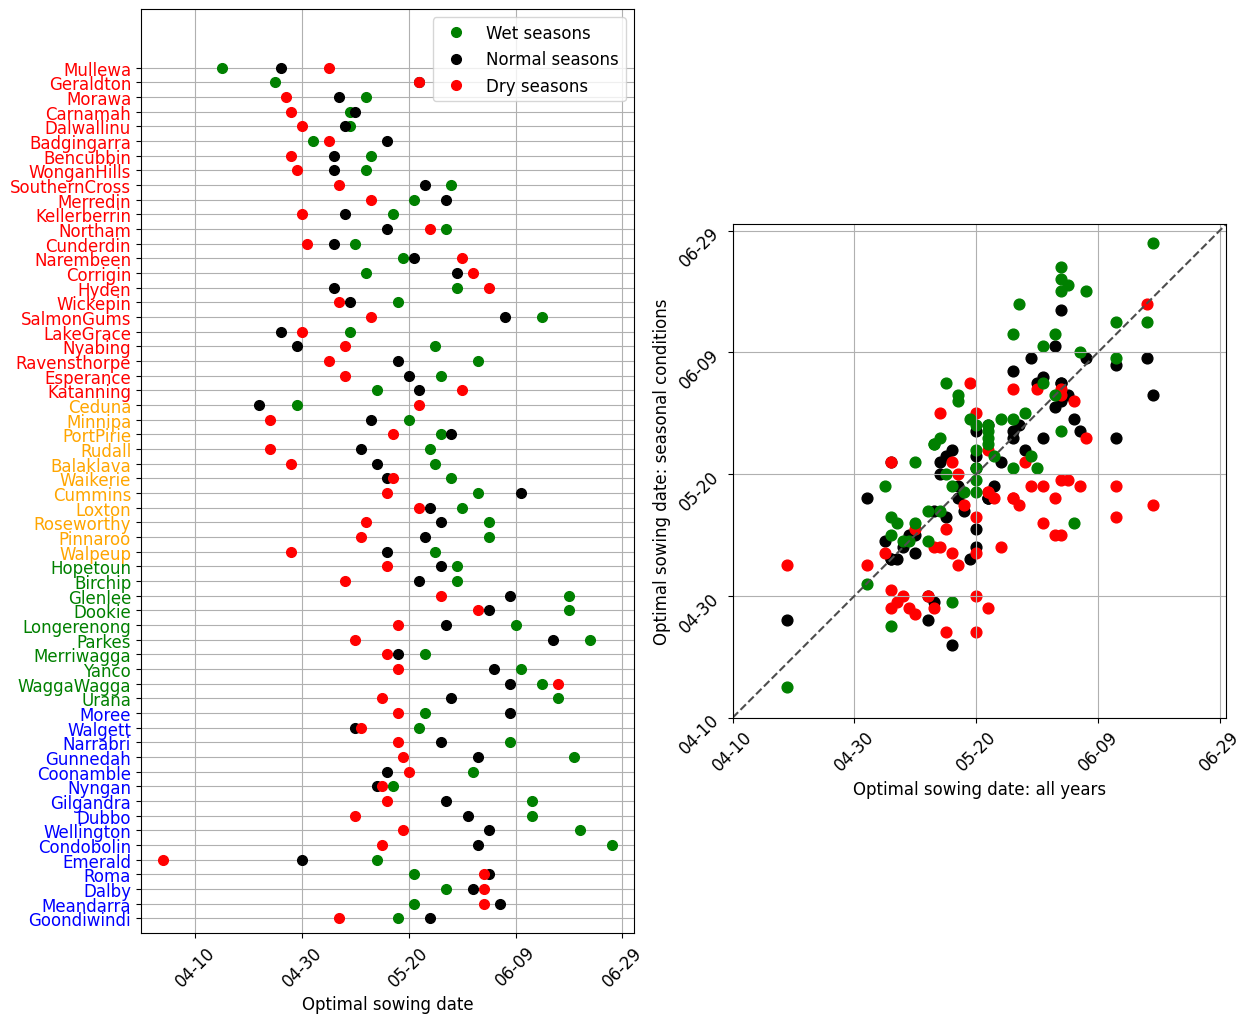

In [61]:
# Plotting optimal sowing dates based on yield performance at all sites
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 12)
ax[0].plot(OS_Y_W, np.arange(1,60,1), 'o', c = 'g', markersize=7)                  # Wet years
#ax[0].plot(OS_Y_N, np.arange(1,60,1), 'o', c = 'k', fillstyle='none', markersize=10)           # Normal years
ax[0].plot(OS_Y_N, np.arange(1,60,1), 'o', c = 'k', markersize=7)           # Normal years
ax[0].plot(OS_Y_D, np.arange(1,60,1), 'o', c = 'r', markersize=7)                  # Dry years
ax[0].legend(['Wet seasons', 'Normal seasons', 'Dry seasons'], fontsize=12)
ax[0].set_yticks(np.arange(1, 60, 1))
ax[0].set_yticklabels(dfS.Sites)
# Using bracket loops for grouping sites in the 4 regions
[ax[0].get_yticklabels()[i].set_color("blue")   for i in np.arange(0,15,1)]          # East region
[ax[0].get_yticklabels()[i].set_color("green")  for i in np.arange(15,25,1)]        # South-East region
[ax[0].get_yticklabels()[i].set_color("orange") for i in np.arange(25,36,1)]       # South region
[ax[0].get_yticklabels()[i].set_color("red")    for i in np.arange(36,59,1)]       # South region
ax[0].set_xticks(np.arange(100, 181, 20))
ax[0].set_xticklabels(sd.loc[np.arange(100, 181, 20)])
ax[0].tick_params(axis = 'x', labelrotation = 45, labelsize = 12)
ax[0].tick_params(axis = 'y', labelsize = 12)
ax[0].set_xlabel('Optimal sowing date', fontsize=12)
ax[0].grid(True)
ax[0].set_ylim(0, 63)
# Scatter plot
ax[1].scatter(OS_Y, OS_Y_N, marker = 'o', c = 'k', s=60)
#ax[1].scatter(OS_Y, OS_Y_N, s=80, facecolors='none', edgecolors='k')
ax[1].scatter(OS_Y, OS_Y_D, marker = 'o', c = 'r', s=60)
ax[1].scatter(OS_Y, OS_Y_W, marker = 'o', c = 'g', s=60)
ax[1].set_aspect('equal')
ax[1].set_xlim(100,181)
ax[1].set_ylim(100,181)
ax[1].plot([100, 181], [100, 181], ls="--", c=".3")
ax[1].set_xticks(np.arange(100, 181, 20))
ax[1].set_xticklabels(sd.loc[np.arange(100, 181, 20)])
ax[1].tick_params(axis = 'x', labelrotation = 45, labelsize = 12)
ax[1].set_yticks(np.arange(100, 181, 20))
ax[1].set_yticklabels(sd.loc[np.arange(100, 181, 20)])
ax[1].tick_params(axis = 'y', labelrotation = 45, labelsize = 12)
ax[1].grid(True)
ax[1].set_xlabel('Optimal sowing date: all years', fontsize=12)
ax[1].set_ylabel('Optimal sowing date: seasonal conditions', fontsize=12)
fig.savefig('OptSow_Yield_All.tiff')

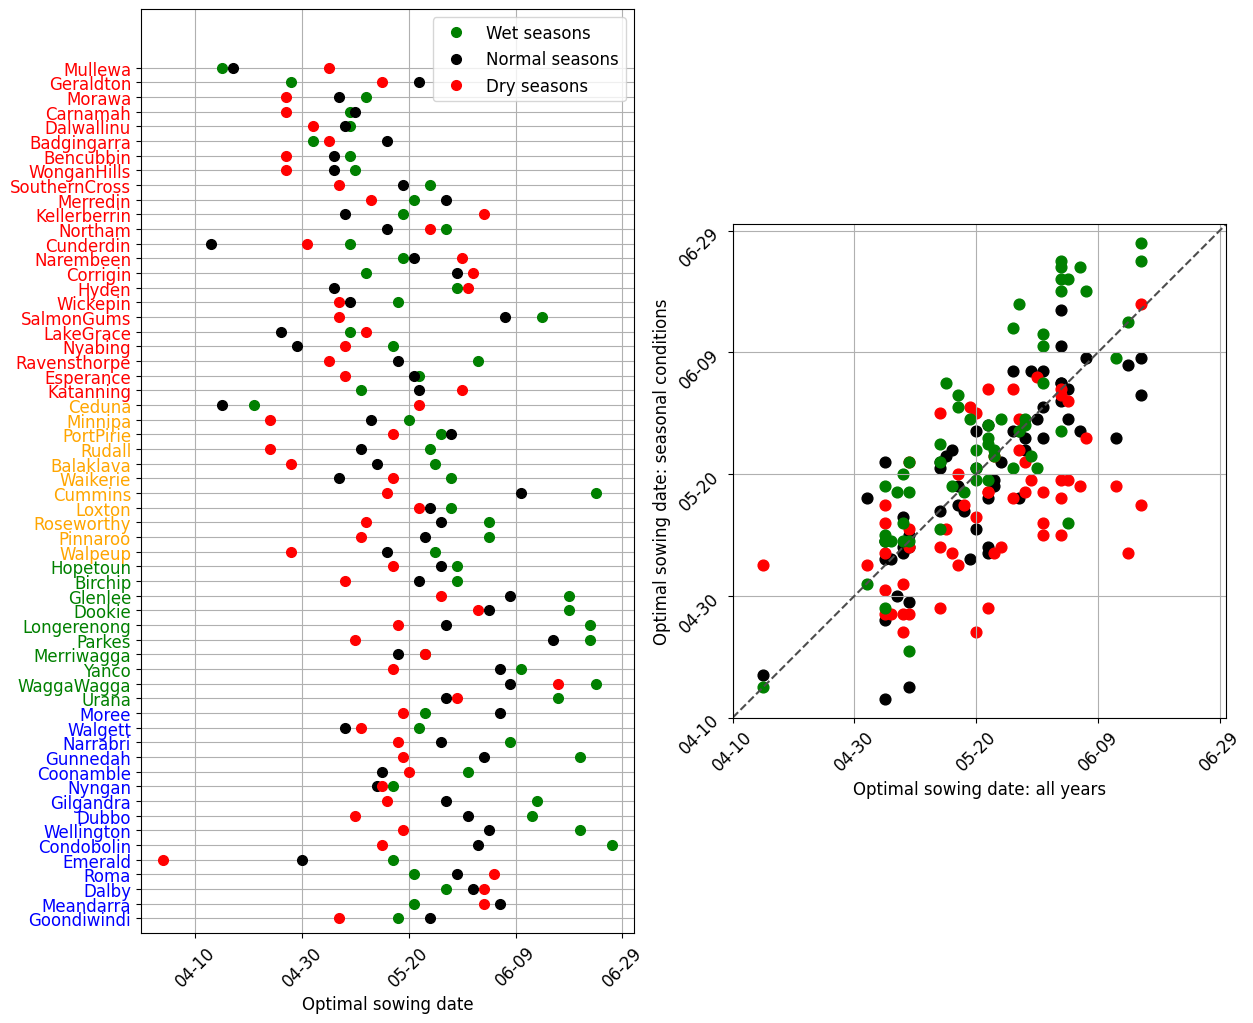

In [62]:
# Plotting optimal sowing dates based on gross margin performance at all sites
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 12)
ax[0].plot(OS_GM_W, np.arange(1,60,1), 'o', c = 'g', markersize=7)                  # Wet years
#ax[0].plot(OS_Y_N, np.arange(1,60,1), 'o', c = 'k', fillstyle='none', markersize=10)           # Normal years
ax[0].plot(OS_GM_N, np.arange(1,60,1), 'o', c = 'k', markersize=7)           # Normal years
ax[0].plot(OS_GM_D, np.arange(1,60,1), 'o', c = 'r', markersize=7)                  # Dry years
ax[0].legend(['Wet seasons', 'Normal seasons', 'Dry seasons'], fontsize=12)
ax[0].set_yticks(np.arange(1, 60, 1))
ax[0].set_yticklabels(dfS.Sites)
# Using bracket loops for grouping sites in the 4 regions
[ax[0].get_yticklabels()[i].set_color("blue")   for i in np.arange(0,15,1)]          # East region
[ax[0].get_yticklabels()[i].set_color("green")  for i in np.arange(15,25,1)]        # South-East region
[ax[0].get_yticklabels()[i].set_color("orange") for i in np.arange(25,36,1)]       # South region
[ax[0].get_yticklabels()[i].set_color("red")    for i in np.arange(36,59,1)]       # South region
ax[0].set_xticks(np.arange(100, 181, 20))
ax[0].set_xticklabels(sd.loc[np.arange(100, 181, 20)])
ax[0].tick_params(axis = 'x', labelrotation = 45, labelsize = 12)
ax[0].tick_params(axis = 'y', labelsize = 12)
ax[0].set_xlabel('Optimal sowing date', fontsize=12)
ax[0].grid(True)
ax[0].set_ylim(0, 63)
# Scatter plot
ax[1].scatter(OS_GM, OS_GM_N, marker = 'o', c = 'k', s=60)
#ax[1].scatter(OS_Y, OS_Y_N, s=80, facecolors='none', edgecolors='k')
ax[1].scatter(OS_GM, OS_GM_D, marker = 'o', c = 'r', s=60)
ax[1].scatter(OS_GM, OS_GM_W, marker = 'o', c = 'g', s=60)
ax[1].set_aspect('equal')
ax[1].set_xlim(100,181)
ax[1].set_ylim(100,181)
ax[1].plot([100, 181], [100, 181], ls="--", c=".3")
ax[1].set_xticks(np.arange(100, 181, 20))
ax[1].set_xticklabels(sd.loc[np.arange(100, 181, 20)])
ax[1].tick_params(axis = 'x', labelrotation = 45, labelsize = 12)
ax[1].set_yticks(np.arange(100, 181, 20))
ax[1].set_yticklabels(sd.loc[np.arange(100, 181, 20)])
ax[1].tick_params(axis = 'y', labelrotation = 45, labelsize = 12)
ax[1].grid(True)
ax[1].set_xlabel('Optimal sowing date: all years', fontsize=12)
ax[1].set_ylabel('Optimal sowing date: seasonal conditions', fontsize=12)
fig.savefig('OptSow_GM_All.tiff')

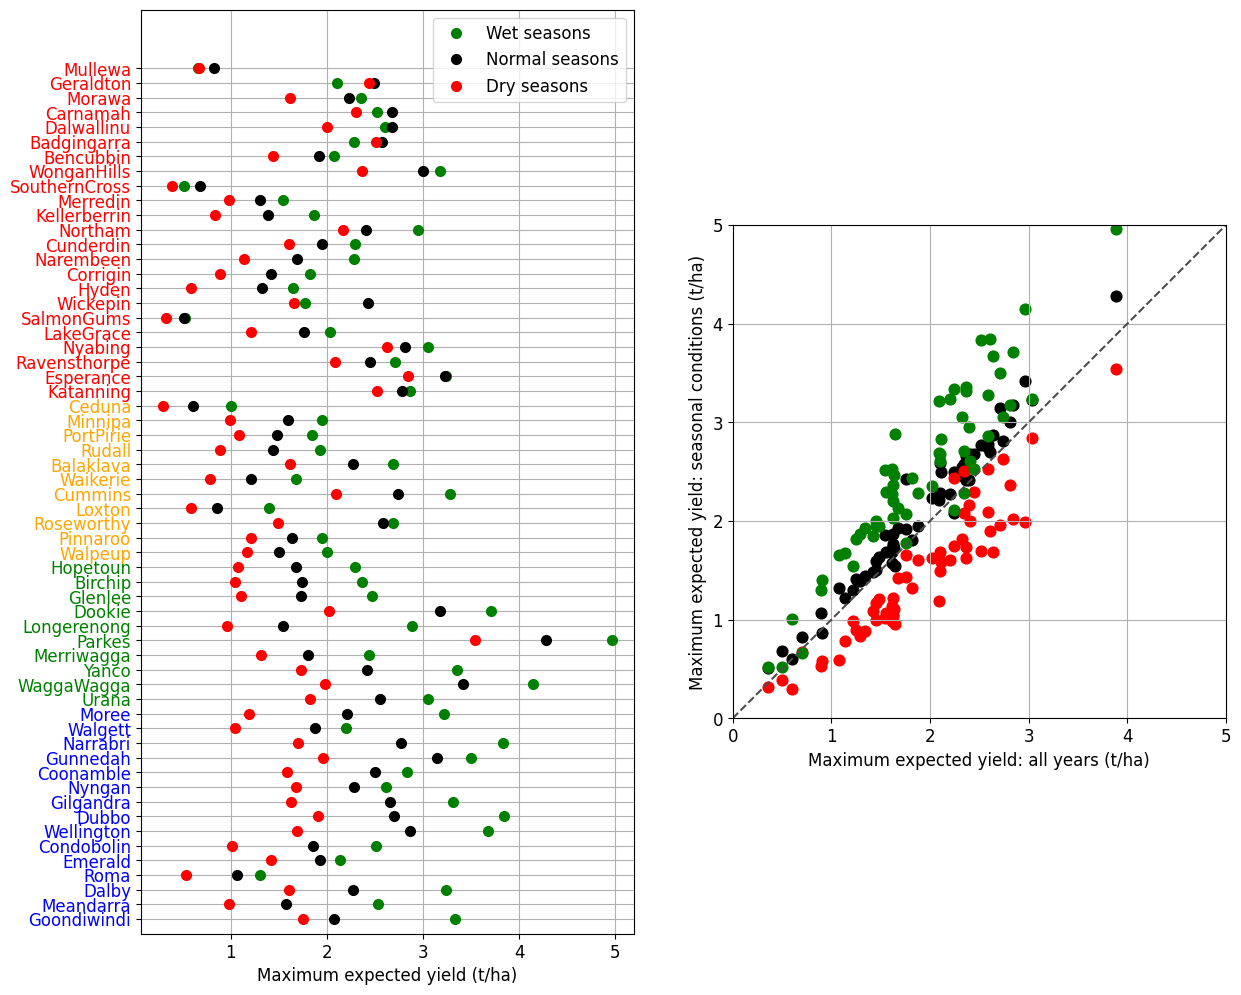

In [63]:
# Plotting maximum yields at all sites
MaxYt = ((pd.Series(MaxY))*0.001).tolist()                         # Convert to t/ha
MaxYt_W = ((pd.Series(MaxY_W))*0.001).tolist()
MaxYt_N = ((pd.Series(MaxY_N))*0.001).tolist()
MaxYt_D = ((pd.Series(MaxY_D))*0.001).tolist()
#
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 12)
ax[0].plot(MaxYt_W, np.arange(1,60,1), 'o', c = 'g', markersize=7)                  # Wet years
#ax[0].plot(OS_Y_N, np.arange(1,60,1), 'o', c = 'k', fillstyle='none', markersize=10)           # Normal years
ax[0].plot(MaxYt_N, np.arange(1,60,1), 'o', c = 'k', markersize=7)           # Normal years
ax[0].plot(MaxYt_D, np.arange(1,60,1), 'o', c = 'r', markersize=7)                  # Dry years
ax[0].legend(['Wet seasons', 'Normal seasons', 'Dry seasons'], fontsize=12)
ax[0].set_yticks(np.arange(1, 60, 1))
ax[0].set_yticklabels(dfS.Sites)
# Using bracket loops for grouping sites in the 4 regions
[ax[0].get_yticklabels()[i].set_color("blue")   for i in np.arange(0,15,1)]          # East region
[ax[0].get_yticklabels()[i].set_color("green")  for i in np.arange(15,25,1)]        # South-East region
[ax[0].get_yticklabels()[i].set_color("orange") for i in np.arange(25,36,1)]       # South region
[ax[0].get_yticklabels()[i].set_color("red")    for i in np.arange(36,59,1)]       # South region
#ax[0].set_xticks(np.arange(100, 181, 20))
#ax[0].set_xticklabels(sd.loc[np.arange(100, 181, 20)])
ax[0].tick_params(axis = 'x', labelrotation = 0, labelsize = 12)
ax[0].tick_params(axis = 'y', labelsize = 12)
ax[0].set_xlabel('Maximum expected yield (t/ha)', fontsize=12)
ax[0].grid(True)
ax[0].set_ylim(0, 63)
# Scatter plot
ax[1].scatter(MaxYt, MaxYt_N, marker = 'o', c = 'k', s=60)
#ax[1].scatter(OS_Y, OS_Y_N, s=80, facecolors='none', edgecolors='k')
ax[1].scatter(MaxYt, MaxYt_D, marker = 'o', c = 'r', s=60)
ax[1].scatter(MaxYt, MaxYt_W, marker = 'o', c = 'g', s=60)
ax[1].set_aspect('equal')
ax[1].set_xlim(0,5)
ax[1].set_ylim(0,5)
ax[1].plot([0, 5], [0, 5], ls="--", c=".3")
#ax[1].set_xticks(np.arange(100, 181, 20))
#ax[1].set_xticklabels(sd.loc[np.arange(100, 181, 20)])
ax[1].tick_params(axis = 'x', labelrotation = 0, labelsize = 12)
#ax[1].set_yticks(np.arange(100, 181, 20))
#ax[1].set_yticklabels(sd.loc[np.arange(100, 181, 20)])
ax[1].tick_params(axis = 'y', labelrotation = 0, labelsize = 12)
ax[1].grid(True)
ax[1].set_xlabel('Maximum expected yield: all years (t/ha)', fontsize=12)
ax[1].set_ylabel('Maximum expected yield: seasonal conditions (t/ha)', fontsize=12)
fig.savefig('MaxY_All.tiff')

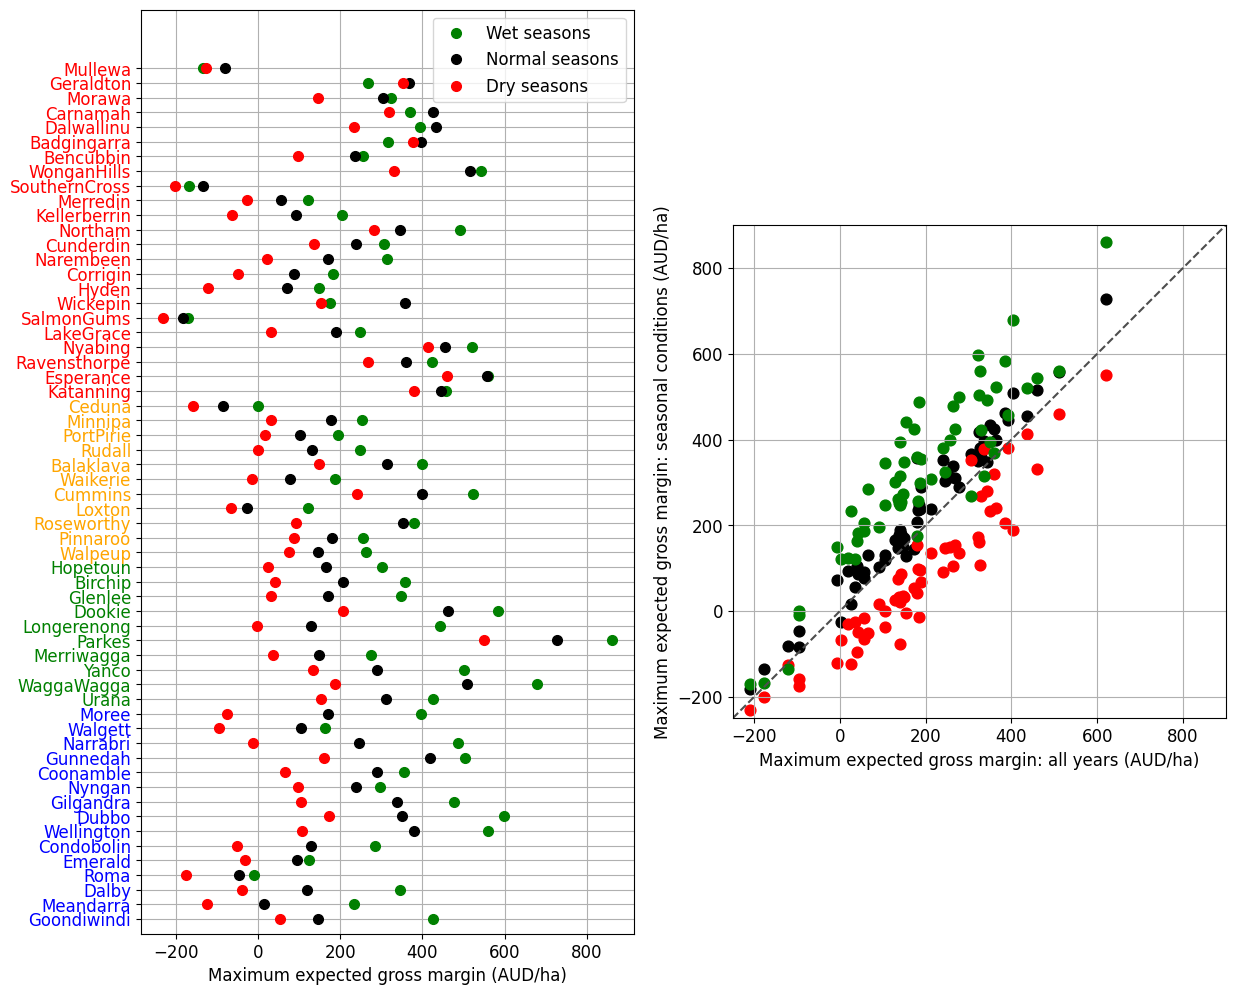

In [64]:
# Plotting maximum gross margin at all sites
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 12)
ax[0].plot(MaxGM_W, np.arange(1,60,1), 'o', c = 'g', markersize=7)                  # Wet years
#ax[0].plot(OS_Y_N, np.arange(1,60,1), 'o', c = 'k', fillstyle='none', markersize=10)           # Normal years
ax[0].plot(MaxGM_N, np.arange(1,60,1), 'o', c = 'k', markersize=7)           # Normal years
ax[0].plot(MaxGM_D, np.arange(1,60,1), 'o', c = 'r', markersize=7)                  # Dry years
ax[0].legend(['Wet seasons', 'Normal seasons', 'Dry seasons'], fontsize=12)
ax[0].set_yticks(np.arange(1, 60, 1))
ax[0].set_yticklabels(dfS.Sites)
# Using bracket loops for grouping sites in the 4 regions
[ax[0].get_yticklabels()[i].set_color("blue")   for i in np.arange(0,15,1)]          # East region
[ax[0].get_yticklabels()[i].set_color("green")  for i in np.arange(15,25,1)]        # South-East region
[ax[0].get_yticklabels()[i].set_color("orange") for i in np.arange(25,36,1)]       # South region
[ax[0].get_yticklabels()[i].set_color("red")    for i in np.arange(36,59,1)]       # South region
#ax[0].set_xticks(np.arange(100, 181, 20))
#ax[0].set_xticklabels(sd.loc[np.arange(100, 181, 20)])
ax[0].tick_params(axis = 'x', labelrotation = 0, labelsize = 12)
ax[0].tick_params(axis = 'y', labelsize = 12)
ax[0].set_xlabel('Maximum expected gross margin (AUD/ha)', fontsize=12)
ax[0].grid(True)
ax[0].set_ylim(0, 63)
# Scatter plot
ax[1].scatter(MaxGM, MaxGM_N, marker = 'o', c = 'k', s=60)
#ax[1].scatter(OS_Y, OS_Y_N, s=80, facecolors='none', edgecolors='k')
ax[1].scatter(MaxGM, MaxGM_D, marker = 'o', c = 'r', s=60)
ax[1].scatter(MaxGM, MaxGM_W, marker = 'o', c = 'g', s=60)
ax[1].set_aspect('equal')
ax[1].set_xlim(-250,900)
ax[1].set_ylim(-250,900)
ax[1].plot([-250, 900], [-250, 900], ls="--", c=".3")
#ax[1].set_xticks(np.arange(100, 181, 20))
#ax[1].set_xticklabels(sd.loc[np.arange(100, 181, 20)])
ax[1].tick_params(axis = 'x', labelrotation = 0, labelsize = 12)
#ax[1].set_yticks(np.arange(100, 181, 20))
#ax[1].set_yticklabels(sd.loc[np.arange(100, 181, 20)])
ax[1].tick_params(axis = 'y', labelrotation = 0, labelsize = 12)
ax[1].grid(True)
ax[1].set_xlabel('Maximum expected gross margin: all years (AUD/ha)', fontsize=12)
ax[1].set_ylabel('Maximum expected gross margin: seasonal conditions (AUD/ha)', fontsize=12)
fig.savefig('MaxGM_All.tiff')

In [34]:
dfGMs.Roma

91    -276.297784
92    -275.875961
93    -276.671755
94    -277.668403
95    -278.184778
          ...    
177   -147.349033
178   -147.681340
179   -149.581030
180   -147.797641
181   -148.316969
Name: Roma, Length: 91, dtype: float64

In [35]:
dfYs.SalmonGums.max()

358.0950486939478

In [43]:
dF = pd.read_parquet('part-0.parquet', engine='pyarrow')

In [44]:
dF

,SowYear,nitrogen,sowing_date,cultivar,soilwater,post_heading_sensitivity,frost_impact,yield,yield_fh
0,1957.0,0,01-Apr,Early,1,-5,1.0,366.8,366.8000
1,1958.0,0,01-Apr,Early,1,-5,1.0,687.6,687.6000
2,1959.0,0,01-Apr,Early,1,-5,1.0,335.4,335.4000
3,1960.0,0,01-Apr,Early,1,-5,1.0,1163.3,1163.3000
4,1961.0,0,01-Apr,Early,1,-5,1.0,1456.0,1456.0000
...,...,...,...,...,...,...,...,...,...
7985245,2017.0,80,30-Jun,Late,5,TT,1.0,1298.4,429.7704
7985246,2018.0,80,30-Jun,Late,5,TT,1.0,1083.2,623.9232
7985247,2019.0,80,30-Jun,Late,5,TT,1.0,1170.4,289.0888
7985248,2020.0,80,30-Jun,Late,5,TT,1.0,1097.8,506.0858


In [60]:
dF.frost_impact[1]

1.0